# Contractor analysis
#### Segmentation of contractor using different clustering technique 

## Import required python libraries

In [481]:
import tables
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import heapq
from sklearn.metrics import silhouette_score
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import MinMaxScaler
from google.cloud import bigquery
from datetime import datetime, timedelta
import time
import json
import pandas as pd
import csv
import string
pd.options.display.max_colwidth = 500
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
import seaborn as sns

## Read from bigquery

In [9]:
client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))
# read data main table for model
query = """
    select * FROM `*****` 
"""
raw_data = pd.read_gbq(query, dialect='standard')

query = """
    select * FROM `***` 
"""
#sales_data = pd.read_gbq(query, dialect='standard')


raw_data.shape

#### Sales table

In [3]:
import re

query = """
SELECT * FROM `**`
"""
sales_2019 = pd.read_gbq(query, dialect='standard')
query = """
SELECT * FROM `**`
"""
sales_2020 = pd.read_gbq(query, dialect='standard')
sales_2019.head(2)

sales_2020['_2020_Low_Slope_Commercial']=sales_2020['Business_Area'].apply(lambda x: 1 if x == "Low Slope - Commercial" else 0)
sales_2020['_2020_Steep_Slope_Residential']=sales_2020['Business_Area'].apply(lambda x: 1 if x == "Steep Slope - Residential" else 0)

sales_2019['_2019_Low_Slope_Commercial']=sales_2019['Business_Area'].apply(lambda x: 1 if x == "Low Slope - Commercial" else 0)
sales_2019['_2019_Steep_Slope_Residential']=sales_2019['Business_Area'].apply(lambda x: 1 if x == "Steep Slope - Residential" else 0)

sales_2019['Total']=sales_2019['Total'].apply(lambda x: re.sub('[^0-9]','', x))
sales_2020['Total']=sales_2020['Total'].apply(lambda x: re.sub('[^0-9]','', x))

sales_2019['Total']=pd.to_numeric(sales_2019['Total'],errors='coerce')
sales_2020['Total']=pd.to_numeric(sales_2020['Total'],errors='coerce')

sales_2020['Total_sales']=sales_2020['Total']
sales_2019['Total_sales']=sales_2019['Total']

del sales_2020['Total']
del sales_2019['Total']



#_2020_Low_Slope_Commercial	_2020_Steep_Slope_Residential



Downloading: 100%|██████████| 148/148 [00:00<00:00, 441.49rows/s]


In [2]:
#print(raw_data.shape)
#raw_data.head(2)
#raw_data['total_invoice_units']

#### Filter USA

In [483]:
raw_data=raw_data[raw_data['country']=='USA']

#print(raw_data.iloc[:, 9:20].describe(include='all'))
print('raw data for USA',raw_data.shape)


raw data for USA (22090, 45)


In [484]:
#raw_data.head(2)

In [485]:
# print(raw_data['Warranty'].value_counts())
# # Warranty=1 11351 record
# print(raw_data['Guarantee'].value_counts())
# # Guarantee=1 9532 record


## Descriptive statistics

In [486]:
# len(raw_data['cust_id'].value_counts())
# raw_data['count_master'].value_counts()

In [487]:
print('Numerical columns')
numeric_column=[]    
for c in raw_data.columns:
    if len(raw_data[c].value_counts()) >= 5:
        numeric_column.append(c)
        print(c)

Numerical columns
company_name
state
cust_id
count_master
count_certified
count_master_elite
count_CERTIFICATION_LEVEL_AUTHORIZED_LS
count_CERTIFICATION_LEVEL_MASTER_SELECT
points_available
points_redeemed
total_invoice_units
total_value_of_invoices_submitted_ytd
roof_area


In [505]:
cat_column=[]    
for c in raw_data.columns:
    if len(raw_data[c].value_counts()) <5:
        cat_column.append(c)
        #print(c)
        #print('Distinct count\n',raw_data[c].value_counts())

raw_data[numeric_column].iloc[:,3:8].describe(include='all')


,count_master,count_certified,count_master_elite,count_CERTIFICATION_LEVEL_AUTHORIZED_LS,count_CERTIFICATION_LEVEL_MASTER_SELECT
count,22087.000000,22087.000000,22087.00000,22087.000000,22087.000000
mean,0.389098,0.701318,0.50532,0.061303,0.154842
std,1.440198,1.776630,2.08598,0.403563,1.020581
min,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.000000,0.000000,0.00000,0.000000,0.000000
75%,0.000000,0.000000,0.00000,0.000000,0.000000
max,11.000000,13.000000,21.00000,9.000000,11.000000


In [510]:
raw_data[numeric_column].iloc[:,8:14].describe(include='all')


,points_available,points_redeemed,total_invoice_units,total_value_of_invoices_submitted_ytd,roof_area
count,5009.000000,5.009000e+03,5009.000000,5.009000e+03,14359.000000
mean,2863.776448,2.842423e+03,551.620058,3.541616e+04,90.785557
std,12754.542416,2.557786e+04,2122.618167,1.151613e+05,312.342001
min,-7589.000000,0.000000e+00,-45.000000,-3.126000e+03,0.000000
25%,50.000000,0.000000e+00,0.000000,0.000000e+00,28.000000
50%,299.260000,0.000000e+00,52.666600,4.640550e+03,38.187500
75%,1396.410000,5.000000e+02,412.777000,3.184650e+04,76.800926
max,270120.840000,1.299987e+06,66807.205000,3.821695e+06,26723.333333


#### Scatter matrix for below columns

In [511]:
num=['points_available','points_redeemed','total_invoice_units','total_value_of_invoices_submitted_ytd','roof_area']


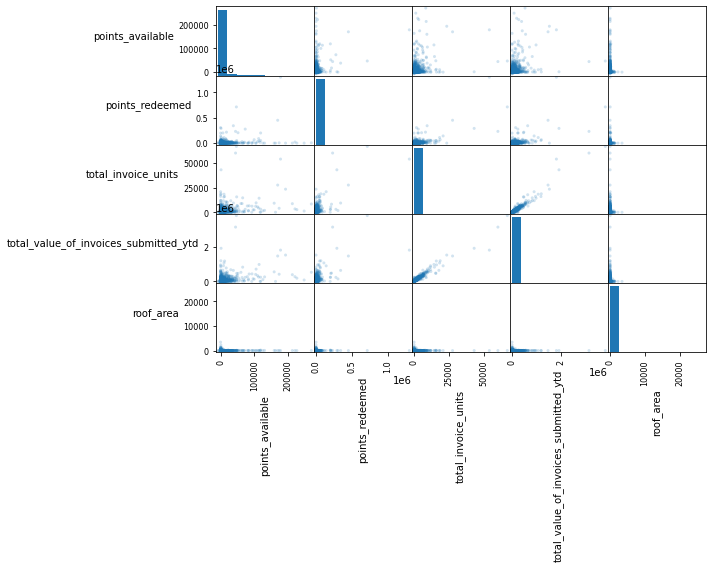

In [512]:
# scatter matrix
import plotly

df=raw_data[num]
import plotly.express as px
from pandas.plotting import scatter_matrix
# fig = px.scatter_matrix(df)
# fig.show()

axes = pd.plotting.scatter_matrix(df, alpha=0.2, figsize=[10, 8])
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
    
plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.ylabel('ylabel', fontsize=16)
plt.show()


#### Numeric columns for showing 5-95% dtributions


5%-95% distribution for  _2019_Low_Slope_Commercial


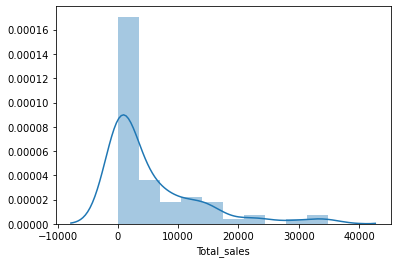

5%-95% distribution for  _2019_Steep_Slope_Residential


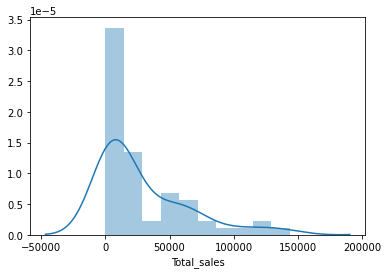

5%-95% distribution for  _2020_Low_Slope_Commercial


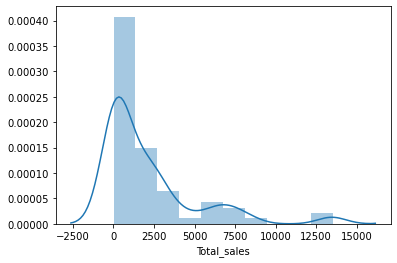

5%-95% distribution for  _2020_Steep_Slope_Residential


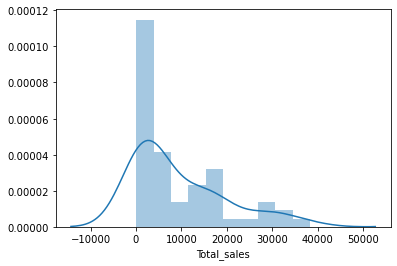

In [68]:
# Sales data

def sales(df1,c1):
    
    df1=df1[df1[c1]==1]
    print('5%-95% distribution for ',c1)
    #quantile
    p=df1['Total_sales'].quantile(0.95)
    n=df1['Total_sales'].quantile(0.05)
    df1=df1[(df1['Total_sales']<p) & (df1['Total_sales']>n)]
    #print(df1.shape)
    sns.distplot(df1['Total_sales'],bins=10)
    plt.show()
    
    
df1=sales_2019
c1='_2019_Low_Slope_Commercial'
df1=df1[df1[c1]==1]
sales(df1,c1)

df1=sales_2019
c1='_2019_Steep_Slope_Residential'
df1=df1[df1[c1]==1]
sales(df1,c1)

df1=sales_2020
c1='_2020_Low_Slope_Commercial'
df1=df1[df1[c1]==1]
sales(df1,c1)

df1=sales_2020
c1='_2020_Steep_Slope_Residential'
df1=df1[df1[c1]==1]
sales(df1,c1)




5%-95% distribution for  points_available
(4508, 45)


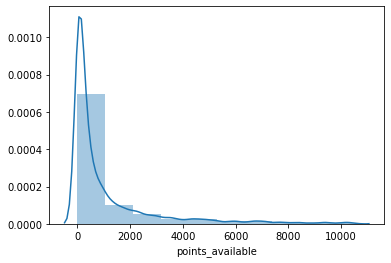

5%-95% distribution for  points_redeemed
(1382, 45)


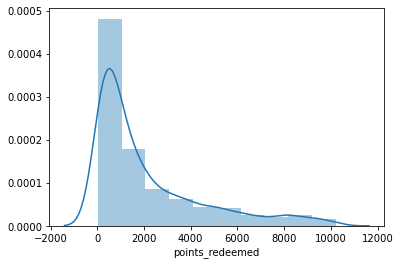

5%-95% distribution for  total_invoice_units
(2882, 45)


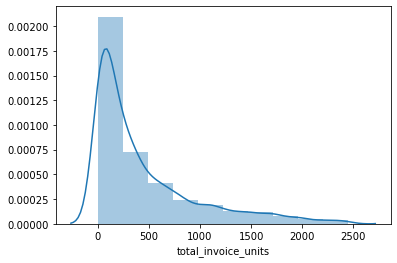

5%-95% distribution for  total_value_of_invoices_submitted_ytd
(2885, 45)


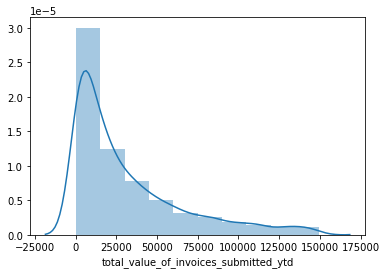

5%-95% distribution for  roof_area
(13489, 45)


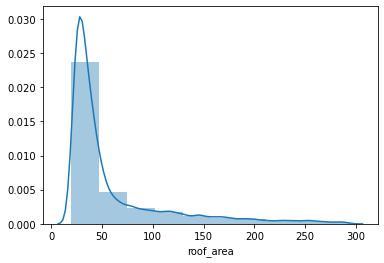

In [116]:
# bar plot or PDF plot
for c in raw_data.columns:
    if c in num:
        print('5%-95% distribution for ',c)
        df=raw_data.copy()
        
        #quantile
        p=raw_data[c].quantile(0.95)
        n=raw_data[c].quantile(0.05)
        
        df=raw_data.copy()
        #df=raw_data[np.abs(raw_data[c]-raw_data[c].mean())<=(5*raw_data[c].std())]
        df=raw_data[(raw_data[c]<p) & (raw_data[c]>n)]
        print(df.shape)

        sns.distplot(df[c],bins=10)
        plt.show()

## Clean data

#### remove columns not useful for model


In [513]:
remove_col=['state','cust_id','company_name','country','points_available','points_redeemed',
'CERTIFICATION_LEVEL_MASTER','CERTIFICATION_LEVEL_CERTIFIED','CERTIFICATION_LEVEL_MASTER_ELITE',
            'CERTIFICATION_LEVEL_AUTHORIZED_LS','CERTIFICATION_LEVEL_MASTER_SELECT','CERTIFICATION_LEVEL_REWARDS']

In [514]:

print(raw_data.shape)
clean_data=raw_data.copy()

#removed nonrequired columns
clean_data=clean_data.drop(remove_col,axis=1)
print(clean_data.shape)


(22090, 45)
(22090, 33)


#### Store frequency of catagorigal data in csv

In [515]:
df1=pd.DataFrame()
for c in clean_data.columns:
    if len(clean_data[c].value_counts()) <= 20:
        l1=clean_data[c].value_counts().index.tolist()
        l2=clean_data[c].value_counts().tolist()
        #print(l1,l2)
        df=pd.DataFrame()
        c1=[c] * len(l1)
        #print(c1)
        df['Variable']=c1
        df['Data']=l1
        df['Frequency']=l2
        if df1.empty:
            df1=df
        else:    
            df1=df1.append(df)

        
    else:
        print('pass*****',c)
df1=df1.reset_index()    
print(df1)        
#df1.to_csv('temp.csv')        


pass***** count_master_elite
pass***** total_invoice_units
pass***** total_value_of_invoices_submitted_ytd
pass***** roof_area
     index                          Variable  Data  Frequency
0        0                      count_master   0.0      19994
1        1                      count_master   1.0        407
2        2                      count_master   2.0        330
3        3                      count_master   3.0        298
4        4                      count_master   4.0        214
..     ...                               ...   ...        ...
98       1  guar_warr_type_INTEGRATED_SYSTEM   1.0       1316
99       0                          Warranty   1.0      11351
100      1                          Warranty   0.0       3008
101      0                         Guarantee   0.0       9532
102      1                         Guarantee   1.0       4827

[103 rows x 4 columns]


In [516]:
#fill na 0    
for i in clean_data.columns:
    clean_data[i]=clean_data[i].fillna(0)

    
#convert -ve to 0
clean_data['total_invoice_units']=clean_data['total_invoice_units'].apply(lambda x: 0 if x < 0 else x)
clean_data['total_value_of_invoices_submitted_ytd']=clean_data['total_value_of_invoices_submitted_ytd'].apply(lambda x: 0 if x < 0 else x)


In [517]:
clean_data['total_value_of_invoices_submitted_ytd'].quantile(0.95)
print('count of 0 for total_value_of_invoices_submitted_ytd ',clean_data[clean_data['total_value_of_invoices_submitted_ytd']==0].shape[0])
print('count of 0 for total_invoice_units ',clean_data[clean_data['total_invoice_units']==0].shape[0])
print('count of 0 for roof_area ',clean_data[clean_data['roof_area']==0].shape[0])


count of 0 for total_value_of_invoices_submitted_ytd  18954
count of 0 for total_invoice_units  18957
count of 0 for roof_area  7742


In [518]:
#convert to catagory with <25% as 1, > 75% as 3, else 2   
def cat(x):
    if x<=l:
        return 1
    elif x > l and x<h:
        return 2
    else:
        return 3

c='total_invoice_units'
# first take 5-95% data then take 25 and 75%    
p=clean_data[c].quantile(0.95)
n=clean_data[c].quantile(0.05)
#temp=clean_data[(clean_data['roof_area']>=n) | (clean_data['roof_area']<=p)]
temp=clean_data.copy()
h=temp[c].quantile(0.75)
l=temp[c].quantile(0.25)
print('25 and 75% value',l,h)
print('below 25%', clean_data[clean_data[c]<=l].shape[0])
print('above 75%', clean_data[clean_data[c]>=h].shape[0])
print('total', clean_data.shape[0])
clean_data[c]=clean_data[c].apply(cat)

c='total_value_of_invoices_submitted_ytd'
# first take 5-95% data then take 25 and 75%    
p=clean_data[c].quantile(0.95)
n=clean_data[c].quantile(0.05)
#temp=clean_data[(clean_data['roof_area']>=n) | (clean_data['roof_area']<=p)]
temp=clean_data.copy()
h=temp[c].quantile(0.75)
l=temp[c].quantile(0.25)
print('25 and 75% value',l,h)
print('below 25%', clean_data[clean_data[c]<=l].shape[0])
print('above 75%', clean_data[clean_data[c]>=h].shape[0])
print('total', clean_data.shape[0])
clean_data[c]=clean_data[c].apply(cat)

c='roof_area'
# first take 5-95% data then take 25 and 75%    
p=clean_data[c].quantile(0.95)
n=clean_data[c].quantile(0.05)
#temp=clean_data[(clean_data['roof_area']>=n) | (clean_data['roof_area']<=p)]
temp=clean_data.copy()
h=temp[c].quantile(0.75)
l=temp[c].quantile(0.25)
print('>=25% and >75% value',l,h)
print('below 25%', clean_data[clean_data[c]<=l].shape[0])
print('above 75%', clean_data[clean_data[c]>h].shape[0])
print('total', clean_data.shape[0])
clean_data[c]=clean_data[c].apply(cat)


#clean_data['total_invoice_units']=clean_data['total_invoice_units'].apply(cat)

# def cat(x):
#     if x<34563:
#         return 1
#     elif x >=34563 and x<311720:
#         return 2
#     else:
#         return 3
# #clean_data['total_value_of_invoices_submitted_ytd']=clean_data['total_value_of_invoices_submitted_ytd'].apply(cat)

# def cat(x):
#     if x<38:
#         return 1
#     elif x >=38 and x<76:
#         return 2
#     else:
#         return 3
# #clean_data['roof_area']=clean_data['roof_area'].apply(cat)

print(clean_data.shape)

25 and 75% value 0.0 0.0
below 25% 18957
above 75% 22090
total 22090
25 and 75% value 0.0 0.0
below 25% 18954
above 75% 22090
total 22090
>=25% and >75% value 0.0 46.107070707070704
below 25% 7742
above 75% 5523
total 22090
(22090, 33)


In [519]:
print('After label encoding frequency')
print(clean_data['roof_area'].value_counts())
print(clean_data['total_invoice_units'].value_counts())
print(clean_data['total_value_of_invoices_submitted_ytd'].value_counts())


After label encoding frequency
2    8825
1    7742
3    5523
Name: roof_area, dtype: int64
1    18957
3     3133
Name: total_invoice_units, dtype: int64
1    18954
3     3136
Name: total_value_of_invoices_submitted_ytd, dtype: int64


In [520]:
#raw_data.head(2)

In [521]:
# convert spend to numeric 1,2,3 corresponding to low,medium,high
#fill na with 0
#clean_data['min_sales_low']=clean_data['min_sales_low'].fillna(0)
#clean_data['min_sales_medium']=clean_data['min_sales_medium'].fillna(0)
#clean_data['min_sales_high']=clean_data['min_sales_high'].fillna(0)
#clean_data['max_sales_low']=clean_data['max_sales_low'].fillna(0)
#clean_data['max_sales_medium']=clean_data['max_sales_medium'].fillna(0)
#clean_data['max_sales_high']=clean_data['max_sales_high'].fillna(0)
#clean_data['avg_sales_low']=clean_data['avg_sales_low'].fillna(0)
#clean_data['avg_sales_medium']=clean_data['avg_sales_medium'].fillna(0)
#clean_data['avg_sales_high']=clean_data['avg_sales_high'].fillna(0)
#clean_data['total_sales_low']=clean_data['total_sales_low'].fillna(0)
#clean_data['total_sales_medium']=clean_data['total_sales_medium'].fillna(0)
#clean_data['total_sales_high']=clean_data['total_sales_high'].fillna(0)

#print('NA value count in total after replacing NA with 0',clean_data[clean_data['total_sales_high'].isna()].shape)

#clean_data=clean_data.drop(['spend'],axis=1)


#create new column
clean_data['total_certifications']=clean_data['count_CERTIFICATION_LEVEL_AUTHORIZED_LS']+clean_data['count_CERTIFICATION_LEVEL_MASTER_SELECT']+ \
                                   clean_data['count_master']+clean_data['count_certified']+clean_data['count_master_elite']



##### check value of distinct counts if > 5 that is if numeric will do label encoding

In [522]:
def cat(x):
    if x<=l:
        return 1
    elif x > l and x<h:
        return 2
    else:
        return 3

for c in clean_data.columns:
    if len(clean_data[c].value_counts()) >= 5:
        numeric_column.append(c)
        print('converting ',c,' into label distince count',len(clean_data[c].value_counts()))
        h=clean_data[c].quantile(0.75)
        l=clean_data[c].quantile(0.25)
        print('25 and 75% value',l,h)
        print('below 25%', clean_data[clean_data[c]<=l].shape[0])
        print('above 75%', clean_data[clean_data[c]>h].shape[0])
        print('total', clean_data.shape[0])
        clean_data[c]=clean_data[c].apply(cat)


        
        

converting  count_master  into label distince count 12
25 and 75% value 0.0 0.0
below 25% 19997
above 75% 2093
total 22090
converting  count_certified  into label distince count 14
25 and 75% value 0.0 0.0
below 25% 17126
above 75% 4964
total 22090
converting  count_master_elite  into label distince count 22
25 and 75% value 0.0 0.0
below 25% 20104
above 75% 1986
total 22090
converting  count_CERTIFICATION_LEVEL_AUTHORIZED_LS  into label distince count 10
25 and 75% value 0.0 0.0
below 25% 21361
above 75% 729
total 22090
converting  count_CERTIFICATION_LEVEL_MASTER_SELECT  into label distince count 12
25 and 75% value 0.0 0.0
below 25% 21475
above 75% 615
total 22090
converting  total_certifications  into label distince count 29
25 and 75% value 0.0 2.0
below 25% 12789
above 75% 5258
total 22090


In [523]:
# sanity check if all are catagorigal now
for c in clean_data.columns:
    if len(clean_data[c].value_counts()) >= 5:
        print(c,' distince count',len(clean_data[c].value_counts()))


In [524]:
clean_data.shape

(22090, 34)

In [525]:
# get std of columns where close < .0001
low_std_col=[]
for i in clean_data.columns:
    std=clean_data[i].std()
    if std < .0001:
        low_std_col.append(i)
        print('std of ',i,std,'removing')
clean_data=clean_data.drop(low_std_col,axis=1)        
       
    


In [526]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
                    print('corr of columns ',corr_matrix.columns[i],corr_matrix.columns[j],corr_matrix.iloc[i, j])

    
    #print(corr_matrix)
    return dataset, col_corr

# remove corelated columns; we are ignoring it as pca/svd we are doing
print('clean_data shape before column deletion for corr',clean_data.shape)    
clean_data, cor_corr = correlation(clean_data,.9)    
print('clean_data shape after column deletion for corr',clean_data.shape)

#print('columns corelated are',cor_corr)    

# check VIF and remove column with vif>5; we are ignoring as pca is done
clean_data_x=add_constant(clean_data)
print('vif table top 5')
#print(pd.Series([vif(clean_data_x.values,i) for i in range(clean_data_x.shape[1])],index=clean_data_x.columns).sort_values(ascending=False)[:5])
viftable=pd.Series([vif(clean_data_x.values,i) for i in range(clean_data_x.shape[1])],index=clean_data_x.columns)
print('vif',viftable)
print('before column deletion for vif',clean_data.shape)
#clean_data=clean_data.drop(list(viftable[viftable>5].index)[1:],axis=1)   # first item is const
print('after column deletion for vif',clean_data.shape)




clean_data shape before column deletion for corr (22090, 34)
corr of columns  CommercialCertification_Master_Select count_CERTIFICATION_LEVEL_MASTER_SELECT 1.0
corr of columns  ResidentialCertification_REWARDS count_CERTIFICATION_LEVEL_REWARDS 0.99981136614697
corr of columns  CommercialCertification_Master count_master 1.0
corr of columns  CommercialCertification_Authorized_LS count_CERTIFICATION_LEVEL_AUTHORIZED_LS 1.0
corr of columns  ResidentialCertification_Master_Elite count_master_elite 1.0
corr of columns  ResidentialCertification_Certified count_certified 1.0
corr of columns  _2020_Low_Slope_Commercial _2019_Low_Slope__Commercial 0.975567971254695
corr of columns  total_value_of_invoices_submitted_ytd total_invoice_units 0.9994424775086669
corr of columns  Warranty guar_warr_type_PLUS 0.9650368752084966
clean_data shape after column deletion for corr (22090, 25)
vif table top 5
vif const                                          318.152179
count_master                          

In [527]:
clean_data.head(1)

,count_master,count_certified,count_master_elite,count_CERTIFICATION_LEVEL_AUTHORIZED_LS,count_CERTIFICATION_LEVEL_MASTER_SELECT,count_CERTIFICATION_LEVEL_REWARDS,Steep_Slope_Residential,Low_Slope_Commercial,_2019_Low_Slope__Commercial,_2019_Steep_Slope_Residential,_2020_Steep_Slope_Residential,total_invoice_units,guar_warr_type_PLUS,guar_warr_type_GOLD,guar_warr_type_CASP,guar_warr_type_EVERGUARD_DIAMOND_PLEDGE,guar_warr_type_SILV,guar_warr_type_RUBEROID_DIAMOND_PLEDGE,guar_warr_type_GAFGLAS_DIAMOND_PLEDGE,guar_warr_type_INTEC_MODIFIED_NDL_GUARANTEE,guar_warr_type_HDPH,guar_warr_type_INTEGRATED_SYSTEM,roof_area,Guarantee,total_certifications
67,1,3,1,1,1,1.0,1.0,0.0,1.0,1.0,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,2


In [528]:
# from sklearn.decomposition import FactorAnalysis
# #clean_data.shape[1]
# transformer = FactorAnalysis(n_components=10, random_state=0)
# X_transformed = transformer.fit_transform(clean_data.values)
# transformer.get_covariance().shape
# FA=pd.DataFrame(transformer.components_,columns=clean_data.columns).T
# #FA=pd.DataFrame(fa.loadings_,index=clean_data.columns)
# for i in range(10):
#     print('variables with good corelation with factor ',i)
#     print('')
#     print(FA[i][FA[i]>.7])

In [529]:
#transformer.score(clean_data.values)
#np.linalg.det(clean_data.values)

In [530]:
## factor analysis
clean_data.head(2)
#'CERTIFICATION_LEVEL_REWARDS','count_CERTIFICATION_LEVEL_REWARDS','ResidentialCertification_REWARDS'


,count_master,count_certified,count_master_elite,count_CERTIFICATION_LEVEL_AUTHORIZED_LS,count_CERTIFICATION_LEVEL_MASTER_SELECT,count_CERTIFICATION_LEVEL_REWARDS,Steep_Slope_Residential,Low_Slope_Commercial,_2019_Low_Slope__Commercial,_2019_Steep_Slope_Residential,_2020_Steep_Slope_Residential,total_invoice_units,guar_warr_type_PLUS,guar_warr_type_GOLD,guar_warr_type_CASP,guar_warr_type_EVERGUARD_DIAMOND_PLEDGE,guar_warr_type_SILV,guar_warr_type_RUBEROID_DIAMOND_PLEDGE,guar_warr_type_GAFGLAS_DIAMOND_PLEDGE,guar_warr_type_INTEC_MODIFIED_NDL_GUARANTEE,guar_warr_type_HDPH,guar_warr_type_INTEGRATED_SYSTEM,roof_area,Guarantee,total_certifications
67,1,3,1,1,1,1.0,1.0,0.0,1.0,1.0,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,2
68,1,1,1,1,1,1.0,1.0,0.0,1.0,1.0,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,1


#### sometimes variable might create matrix singular matrix, non invertible so ignoring this for FA

(22090, 25)
variance, proportional variance and cumulative variance for each factor (array([2.50190248, 2.41102138, 2.17394299, 1.91339356, 1.90218761,
       1.82850519, 1.5143511 , 1.18848219, 1.0967347 , 1.01550085,
       0.22491908, 0.13387477, 0.12991042, 0.08592042, 0.06832071,
       0.05890168, 0.05604558, 0.04574635, 0.04074176, 0.03111286,
       0.02676217, 0.02107086, 0.01976716, 0.01667694, 0.        ]), array([0.1000761 , 0.09644086, 0.08695772, 0.07653574, 0.0760875 ,
       0.07314021, 0.06057404, 0.04753929, 0.04386939, 0.04062003,
       0.00899676, 0.00535499, 0.00519642, 0.00343682, 0.00273283,
       0.00235607, 0.00224182, 0.00182985, 0.00162967, 0.00124451,
       0.00107049, 0.00084283, 0.00079069, 0.00066708, 0.        ]), array([0.1000761 , 0.19651695, 0.28347467, 0.36001042, 0.43609792,
       0.50923813, 0.56981217, 0.61735146, 0.66122085, 0.70184088,
       0.71083765, 0.71619264, 0.72138905, 0.72482587, 0.7275587 ,
       0.72991477, 0.73215659, 0.7339864

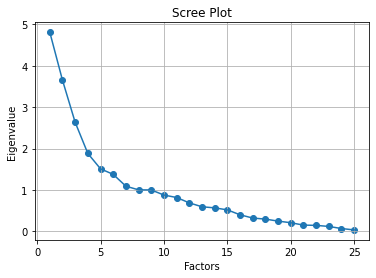

variance, proportional variance and cumulative variance for each factor [0.09877167 0.18864158 0.2774074  0.35924551 0.44043579 0.50655715
 0.56609733 0.61347865 0.65888597 0.70060973]


In [531]:
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer()
#,'ResidentialCertification_REWARDS','count_CERTIFICATION_LEVEL_REWARDS'
##### ** ResidentialCertification_REWARDS making matrix non invertible
#clean_data1=clean_data.drop(['CERTIFICATION_LEVEL_REWARDS'],axis=1)
print(clean_data.shape)
total_comp=clean_data.shape[1]
fa = FactorAnalyzer(rotation="varimax", n_factors = total_comp)
fa.fit_transform(clean_data)

print("variance, proportional variance and cumulative variance for each factor",fa.get_factor_variance())
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
print(ev)
plt.scatter(range(1,clean_data.shape[1]+1),ev)
plt.plot(range(1,clean_data.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

# we see 10 components explain most variance

fa = FactorAnalyzer(rotation="varimax", n_factors  = 10)
fa.fit_transform(clean_data)
#print('loadings',pd.DataFrame(fa.loadings_,index=clean_data.columns))

print("variance, proportional variance and cumulative variance for each factor",fa.get_factor_variance()[2])


In [532]:
optimum_eigen=sum(ev>=1)

fa = FactorAnalyzer(rotation="varimax", n_factors  = optimum_eigen)
fa.fit_transform(clean_data)
#print('loadings',pd.DataFrame(fa.loadings_,index=clean_data.columns))

print("variance, proportional variance and cumulative variance for each factor",fa.get_factor_variance()[2])


variance, proportional variance and cumulative variance for each factor [0.13822225 0.23691354 0.32633683 0.4071147  0.47726843 0.53477844
 0.58458898 0.62624322]


In [533]:
FA=pd.DataFrame(fa.loadings_,index=clean_data.columns)
for i in range(optimum_eigen):
    print('variables with good corelation with factor ',i)
    print('')
    print(FA[i][FA[i]>.7])

variables with good corelation with factor  0

guar_warr_type_EVERGUARD_DIAMOND_PLEDGE    0.702255
guar_warr_type_RUBEROID_DIAMOND_PLEDGE     0.799502
guar_warr_type_GAFGLAS_DIAMOND_PLEDGE      0.741853
Guarantee                                  0.709854
Name: 0, dtype: float64
variables with good corelation with factor  1

_2019_Low_Slope__Commercial      0.876519
_2019_Steep_Slope_Residential    0.902830
_2020_Steep_Slope_Residential    0.934091
Name: 1, dtype: float64
variables with good corelation with factor  2

count_master_elite     0.865070
guar_warr_type_GOLD    0.752228
guar_warr_type_SILV    0.706803
Name: 2, dtype: float64
variables with good corelation with factor  3

count_CERTIFICATION_LEVEL_REWARDS    0.965359
Steep_Slope_Residential              0.788428
Name: 3, dtype: float64
variables with good corelation with factor  4

count_master    0.982913
Name: 4, dtype: float64
variables with good corelation with factor  5

count_certified    0.839268
Name: 5, dtype: float64

In [534]:
# factor 1 has high loadings for the features 
    

## Transform data

In [535]:
# normalize x with 0 and 1 mean and std
#scaler = MinMaxScaler()
clean_data1=clean_data.copy()
scaler = StandardScaler()  #for using pca
scaled = scaler.fit_transform(clean_data)
#print('before transformation',clean_data.values[0:2])

#standarize count related columns and total_certifications for svd
#col=[c for c in clean_data1.columns if 'count' in c]
#col.append('total_certifications')

# for c in col:
#     scaler1 = MinMaxScaler()
#     scaled1 = scaler1.fit_transform(clean_data1[c].values.reshape(-1, 1))
#     clean_data1[c]=scaled1

# This is only standarized to count related columns and total_certifications
x_orig=clean_data1.values


x_std=scaled
unscaled = scaler.inverse_transform(scaled)
#print('aftre denormalizing',unscaled[0:2])

# check how many components required to get 90% variance. for SVD use x_orig no need standarizing
for comp in range(len(x_orig[0])):
    svd = TruncatedSVD(n_components=comp, n_iter=7, random_state=42)
    svd.fit(x_orig)
    v=sum(svd.explained_variance_ratio_)
    if v > .9:
        break
    #print('SVD explained variance with component',comp,' is ',v)   #,svd.explained_variance_ratio_)


# dimension reduction by SVD
print('Before SVD x',x_orig.shape)
svd = TruncatedSVD(n_components=comp, n_iter=7, random_state=42)
svd.fit(x_orig)
print('SVD explained variance',sum(svd.explained_variance_ratio_))   #,svd.explained_variance_ratio_)
x_orig=svd.fit_transform(x_orig)
print('svd singular values',svd.singular_values_)

print('transformed x using SVD',x_orig.shape)

for comp in range(len(x_std[0])):
    svd = TruncatedSVD(n_components=comp, n_iter=7, random_state=42)
    svd.fit(x_std)
    v=sum(svd.explained_variance_ratio_)
    if v > .9:
        break
    #print('PCA explained variance with component',comp,' is ',v)   #,svd.explained_variance_ratio_)
print('Before PCA x',x_std.shape)
pca = PCA(n_components=comp)
pca.fit(x_std)
print('PCA explained variance',sum(pca.explained_variance_ratio_))  #,pca.explained_variance_ratio_)
print('pca eigen values',pca.singular_values_)
x_std=svd.fit_transform(x_std)
print('transformed x using PCA',x_std.shape)

# We have x_std: pca comp of standarize data, x_orig: SVD of original data, 
# because of standarization matrix become dense so pca components are more 
# to explain 90% variance whereas svd components are less to explain 90% of variance as SVD can be used in original data

Before SVD x (22090, 25)
SVD explained variance 0.9024488781577429
svd singular values [785.77707905 176.7506953  147.90520695 121.97863475 105.08017325
  79.12005091  72.56898797  68.68542529  61.96594155  53.32778568]
transformed x using SVD (22090, 10)
Before PCA x (22090, 25)
PCA explained variance 0.9000943444627776
pca eigen values [326.03180108 284.09682081 241.28540215 203.90258678 182.66067004
 174.35224407 155.21272752 148.76783135 148.620416   139.12577569
 134.3352112  123.22687093 114.44814956 111.86943138]
transformed x using PCA (22090, 14)


In [536]:
print(clean_data.shape,x_std[0].shape,x_orig[1].shape)

(22090, 25) (14,) (10,)


In [537]:
clean_data.head(2)

,count_master,count_certified,count_master_elite,count_CERTIFICATION_LEVEL_AUTHORIZED_LS,count_CERTIFICATION_LEVEL_MASTER_SELECT,count_CERTIFICATION_LEVEL_REWARDS,Steep_Slope_Residential,Low_Slope_Commercial,_2019_Low_Slope__Commercial,_2019_Steep_Slope_Residential,_2020_Steep_Slope_Residential,total_invoice_units,guar_warr_type_PLUS,guar_warr_type_GOLD,guar_warr_type_CASP,guar_warr_type_EVERGUARD_DIAMOND_PLEDGE,guar_warr_type_SILV,guar_warr_type_RUBEROID_DIAMOND_PLEDGE,guar_warr_type_GAFGLAS_DIAMOND_PLEDGE,guar_warr_type_INTEC_MODIFIED_NDL_GUARANTEE,guar_warr_type_HDPH,guar_warr_type_INTEGRATED_SYSTEM,roof_area,Guarantee,total_certifications
67,1,3,1,1,1,1.0,1.0,0.0,1.0,1.0,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,2
68,1,1,1,1,1,1.0,1.0,0.0,1.0,1.0,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,1


#### 1. Without removing corelated component(SVD 10 PCA 14), making everything catagorigal, using PCA value silhutte is increasing
![alt text](1.png "Title")
![alt text](2.PNG "Title")
![alt text](3.PNG "Title")
![alt text](4.PNG "Title")


#### 2. Without removing corelated component(SVD 10 PCA 14), making everything catagorigal, using SVD value silhutte is increasing but 18 is peak
#### 3. With removing corelated component(SVD 10 PCA 14), making everything catagorigal, using SVD value silhutte is increasing
#### 4. With removing corelated component(SVD 10 PCA 14), making everything catagorigal, using PCA value silhutte is increasing but 17 is peak



## Kmeans

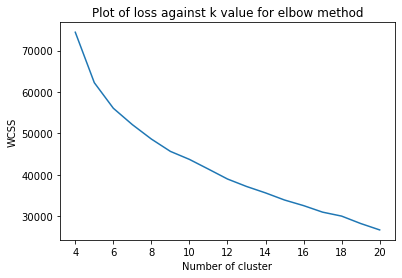

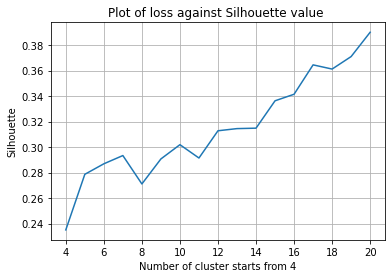

In [538]:
# Elbow method
x=x_orig     # with x_std silhoutte value is increasing
# with x_orig giving 2 clusters

sse = {}
for k in range(4, 21):
    kmeans = KMeans(init='k-means++',n_clusters=k, max_iter=1000,random_state=1).fit(x)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.title("Plot of loss against k value for elbow method")
plt.xlabel("Number of cluster")
plt.ylabel("WCSS")
plt.show()

#The Silhouette Method
sil = []
kmax = 20

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(4, kmax+1):
  kmeans = KMeans(n_clusters = k,random_state=1).fit(x)
  labels = kmeans.labels_
  sil.append(silhouette_score(x, labels, metric = 'euclidean'))

plt.figure()
sil1=[(i+4,item) for i,item in enumerate(sil)]

x_val = [i[0] for i in sil1]
y_val = [i[1] for i in sil1]

plt.plot(x_val,y_val)


plt.title("Plot of loss against Silhouette value ")
plt.xlabel("Number of cluster starts from 4")
plt.ylabel("Silhouette")
plt.grid()
plt.show()

In [416]:
# Use k=2 and build cluster
#kmeans = KMeans(init='k-means++',n_clusters=5, max_iter=100).fit(x)
#print(kmeans.labels_)    
#a=np.where(kmeans.labels_ == 0)[0]
#b=np.where(kmeans.labels_ == 1)[0]
#c=np.where(kmeans.labels_ == 2)[0]
#d=np.where(kmeans.labels_ == 3)[0]
#e=np.where(kmeans.labels_ == 4)[0]
#check 5 text for cluster 1
#print(clean_data.iloc[a.tolist()][:2])
#check 5 text for cluster 1
#print(clean_data.iloc[b.tolist()][:2])
#print(clean_data.iloc[c.tolist()][:2])
#print(clean_data.iloc[d.tolist()][:2])
#print(clean_data.iloc[e.tolist()][:2])


In [417]:
clean_data.shape

(22886, 36)

In [418]:
clean_data.head(2)

,count_master,count_certified,count_master_elite,count_CERTIFICATION_LEVEL_AUTHORIZED_LS,count_CERTIFICATION_LEVEL_MASTER_SELECT,count_CERTIFICATION_LEVEL_REWARDS,Steep_Slope_Residential,Low_Slope_Commercial,CommercialCertification_Master_Select,ResidentialCertification_REWARDS,CommercialCertification_Master,CommercialCertification_Authorized_LS,ResidentialCertification_Master_Elite,ResidentialCertification_Certified,_2019_Low_Slope__Commercial,_2019_Steep_Slope_Residential,_2020_Low_Slope_Commercial,_2020_Steep_Slope_Residential,total_invoice_units,total_value_of_invoices_submitted_ytd,guar_warr_type_PLUS,guar_warr_type_GOLD,guar_warr_type_CASP,guar_warr_type_EVERGUARD_DIAMOND_PLEDGE,guar_warr_type_SILV,guar_warr_type_RUBEROID_DIAMOND_PLEDGE,guar_warr_type_GAFGLAS_DIAMOND_PLEDGE,guar_warr_type_INTEC_MODIFIED_NDL_GUARANTEE,guar_warr_type_HDPH,guar_warr_type_INTEGRATED_SYSTEM,roof_area,Warranty,Guarantee,total_certifications,kmeans_10_cluster,kmeans_10_cluster_score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,6,0.364251
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,6,0.364251


In [419]:
# get top 2 cluster value by Silhouette
top_2=heapq.nlargest(1, sil)
top_2=[sil.index(j)+2 for j in top_2] 
top_2

[18]

#### Use top_2=14

In [539]:
top_2=[7]

#### Create df for storing clean_data with cluster + some columns

In [540]:
# lable will be atttached with data from where model is create
final_data=clean_data.copy()
final_data['cust_id']=raw_data['cust_id']
final_data['state']=raw_data['state']
final_data['company_name']=raw_data['company_name']

#use catagorigal data
#final_data['total_value_of_invoices_submitted_ytd_cat']=clean_data['total_value_of_invoices_submitted_ytd']
#final_data['total_invoice_units_cat']=clean_data['total_invoice_units']


In [541]:
#final_data[final_data['guar_warr_type_HDPH']==1]['kmeans_10_cluster'].value_counts()[:2]

In [542]:
    
def clusterform(n_clusters=2,x=x,cluster_data=clean_data):
    # here no options to choose cosine distance
    kmeans = KMeans(init='k-means++',n_clusters=n_clusters, max_iter=100,random_state=1).fit(x)
    #cluster_data.head(2)
    # show by tsne
    
    return kmeans

def tsne_plot(x=x,cluster_data=clean_data,kmeans=kmeans):
    modeltsne=TSNE(n_components=2,random_state=0)#,perplexity=10,n_iter=250)
    cluster_data['cluster_kmeans']=kmeans.labels_.tolist()
    y=cluster_data['cluster_kmeans'].values
    tsne_data=modeltsne.fit_transform(x)
    #create new data for plotting
    tsne_data=np.vstack((tsne_data.T,y)).T
    tsne_df=pd.DataFrame(data=tsne_data,columns=('Dim1','Dim2','Label'))
    sns.FacetGrid(tsne_df,hue='Label',size=6).map(plt.scatter,'Dim1','Dim2').add_legend()
    plt.show()
    
    

for cluster  7


/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


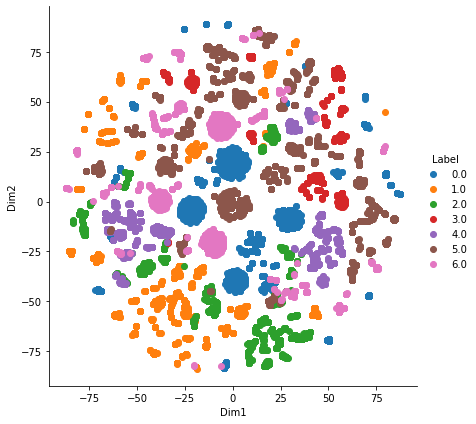

[1 0 0 ... 5 5 5]
model.labels_ value counts value counts dict_values([3277, 4891, 2155, 5518, 1306, 1859, 3084])


In [543]:
import seaborn as sns
from collections import Counter

for cluster in top_2:
    print('for cluster ',cluster)
    model=clusterform(cluster,x,clean_data.copy())
    tsne_plot(x,clean_data.copy(),model)
    print(model.labels_)
    print('model.labels_ value counts','value counts',Counter(model.labels_).values())
    final_data['kmeans_'+str(cluster)+'_cluster']=model.labels_
    final_data['kmeans_'+str(cluster)+'_cluster_score']=silhouette_score(x, model.labels_, metric = 'euclidean')
    clean_data['kmeans_'+str(cluster)+'_cluster']=model.labels_
    clean_data['kmeans_'+str(cluster)+'_cluster_score']=silhouette_score(x, model.labels_, metric = 'euclidean')


In [544]:
final_data.head(2)

# drop final_data['kmeans_13_cluster']
# drop final_data['kmeans_13_cluster_score']


,count_master,count_certified,count_master_elite,count_CERTIFICATION_LEVEL_AUTHORIZED_LS,count_CERTIFICATION_LEVEL_MASTER_SELECT,count_CERTIFICATION_LEVEL_REWARDS,Steep_Slope_Residential,Low_Slope_Commercial,_2019_Low_Slope__Commercial,_2019_Steep_Slope_Residential,_2020_Steep_Slope_Residential,total_invoice_units,guar_warr_type_PLUS,guar_warr_type_GOLD,guar_warr_type_CASP,guar_warr_type_EVERGUARD_DIAMOND_PLEDGE,guar_warr_type_SILV,guar_warr_type_RUBEROID_DIAMOND_PLEDGE,guar_warr_type_GAFGLAS_DIAMOND_PLEDGE,guar_warr_type_INTEC_MODIFIED_NDL_GUARANTEE,guar_warr_type_HDPH,guar_warr_type_INTEGRATED_SYSTEM,roof_area,Guarantee,total_certifications,cust_id,state,company_name,kmeans_7_cluster,kmeans_7_cluster_score
67,1,3,1,1,1,1.0,1.0,0.0,1.0,1.0,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,2,1125043,AK,True North Contracting LLC,1,0.293342
68,1,1,1,1,1,1.0,1.0,0.0,1.0,1.0,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,1,1124684,AK,Olhausen Construction & Management LLC,0,0.293342


In [545]:
## Create a label with kmeans output
print(model.labels_)    
#clean_data['kmeans_label']=kmeans.labels_
#a=np.where(kmeans.labels_ == 0)[0]
#b=np.where(kmeans.labels_ == 1)[0]
clean_data.head(2)

l=model.labels_
print('cluster distribution : ',Counter(l)) 
d=dict(Counter(l))
s=[v for v in d.values()]
d1={k:v*100/sum(s) for k,v in d.items()}
print('Cluster distribution in % : ',d1)

[1 0 0 ... 5 5 5]
cluster distribution :  Counter({5: 5518, 0: 4891, 1: 3277, 6: 3084, 2: 2155, 4: 1859, 3: 1306})
Cluster distribution in % :  {1: 14.834766862833861, 0: 22.141240380262563, 2: 9.755545495699412, 5: 24.979628791308283, 3: 5.912177455862381, 4: 8.415572657311001, 6: 13.9610683567225}


,count_master,count_certified,count_master_elite,count_CERTIFICATION_LEVEL_AUTHORIZED_LS,count_CERTIFICATION_LEVEL_MASTER_SELECT,count_CERTIFICATION_LEVEL_REWARDS,Steep_Slope_Residential,Low_Slope_Commercial,_2019_Low_Slope__Commercial,_2019_Steep_Slope_Residential,_2020_Steep_Slope_Residential,total_invoice_units,guar_warr_type_PLUS,guar_warr_type_GOLD,guar_warr_type_CASP,guar_warr_type_EVERGUARD_DIAMOND_PLEDGE,guar_warr_type_SILV,guar_warr_type_RUBEROID_DIAMOND_PLEDGE,guar_warr_type_GAFGLAS_DIAMOND_PLEDGE,guar_warr_type_INTEC_MODIFIED_NDL_GUARANTEE,guar_warr_type_HDPH,guar_warr_type_INTEGRATED_SYSTEM,roof_area,Guarantee,total_certifications,cust_id,state,company_name,kmeans_7_cluster,kmeans_7_cluster_score
11467,1,1,1,1,1,0.0,0.0,1.0,2.0,2.0,2.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1.0,1,1123806,NC,Robert L Leonard and Co Inc,5,0.293342
19246,1,1,1,1,1,1.0,1.0,0.0,3.0,3.0,3.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,1,1121421,TX,Siebax Enterprises LLC,6,0.293342


In [551]:
# #print(final_data['kmeans_13_cluster'].value_counts())

# l1=[]
# for c in final_data.columns:
#     if 'cluster' not in c:
#         print('for columns..',c)
#         try:
#             print(final_data[final_data[c]==1]['kmeans_17_cluster'].value_counts()[0:1])
#             l=final_data[final_data[c]==1]['kmeans_17_cluster'].value_counts()[0:1].index.tolist()
#     #         if len(l)==0:
#     #             l=['NA','NA','NA']
#             if len(l)==1:
#                 l.extend(['NA','NA'])

#             elif len(l)==2:
#                 l.append('NA')


#             l.append(c)
#             #print(l)
#             l1.append(l)
#             #print(final_data[final_data[c]==1]['kmeans_13_cluster'].value_counts()[0:3].index.tolist().append(c))
#         except:
#             print('error')
#             continue
# print(l1)
# df=pd.DataFrame(l1,columns=['primary','secondary','tertiary','var'])  

# print(df.shape)  
# df

In [552]:
# #print(final_data['kmeans_17_cluster'].value_counts())
# df=df[~df['var'].isna()]
# df.sort_values(['primary'])


In [553]:
# df

In [554]:
# print('for each cluster major variables contributing')
# print(df['primary'].max())
# l1=[]
# c=1
# for c in range(df['primary'].max()+1):
#     l=' ; '.join(df[df['primary']==c]['var'].tolist())
#     l0=[c]
#     l0.append(l)
#     l1.append(l0)
#     df1=pd.DataFrame(l1,columns=['cluster','important_primary_variables'])  
# df1

In [555]:
# #get top 5 data closest to center
# for c in range(2):
#         d = model.transform(x)[:, c]
#         ind = np.argsort(d)[::-1][:5]
#         print('top 5 in cluster',c)
#         print(raw_data.iloc[ind]['cust_id'])



In [561]:
print('data to be stored',final_data.shape)
print('data on model run',clean_data.shape)

data to be stored (22090, 30)
data on model run (22090, 27)


## Store data to bigquery

In [ ]:
# merge original data with cluster labels
#final_data has input for model
# use_col=[c for c in final_data.columns.tolist() if 'cluster' in c]
# use_col.append('cust_id')
# print(use_col)
# final_data1=final_data[use_col]
# final_data1.head(2)

# #drop columns from bas data where clusetr 
# drop_col=[c for c in base_data.columns.tolist() if 'cluster' in c]
# base_data1=base_data.drop(drop_col,axis=1)
# print(base_data1.shape)
# print(base_data.shape)

# #final2 has data original+cluster label
# final2=pd.merge(base_data1,final_data1,how='left', on='cust_id')
# print(final_data1.shape,base_data1.shape,final2.shape)

# Store feature data with label
#

In [ ]:
#final_data.to_gbq(destination_table='Contractor_Cluster.Contractor_Featured_Cluster_updated_20_5_temp',project_id = '*',if_exists = 'replace')  #'replace')

## Find important feature in cluster

In [564]:
# for kmeans run a decision tree and find most important feature to identify clusters
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
drop_col=[c for c in clean_data.columns.tolist() if 'cluster' in c]
x=clean_data.drop(drop_col, axis=1).values 
y=clean_data['kmeans_'+str(top_2[0])+'_cluster']
clf.fit(x, y)
#feat_importance = clf.tree_.compute_feature_importances(normalize=False)
feat_importance=clf.feature_importances_
print("feat importance = " + str(feat_importance))
good_features=[]
for importance, name in sorted(zip(clf.feature_importances_, clean_data.drop(['kmeans_'+str(top_2[0])+'_cluster'], axis=1).columns),reverse=True)[:10]:
    print (name, importance)
    good_features.append(name)
    
good_features

feat importance = [2.67766348e-02 1.07679881e-01 7.03012677e-02 3.66859069e-03
 3.72105251e-03 1.86928363e-02 3.11220763e-02 3.05575599e-02
 5.64332366e-02 8.03247015e-02 5.95403048e-02 8.58818943e-02
 6.15667301e-02 1.30909779e-02 3.06070812e-05 1.62035873e-02
 7.63990291e-03 3.80183829e-03 2.82011748e-03 6.03902323e-04
 9.17606864e-08 1.46879981e-03 1.47304838e-01 2.79872767e-02
 1.42781294e-01]
roof_area 0.14730483827989643
total_certifications 0.14278129376669657
count_certified 0.10767988075165809
total_invoice_units 0.08588189434233852
_2019_Steep_Slope_Residential 0.08032470147608586
count_master_elite 0.07030126774547885
guar_warr_type_PLUS 0.06156673012779641
_2020_Steep_Slope_Residential 0.05954030481170419
_2019_Low_Slope__Commercial 0.05643323663701956
Steep_Slope_Residential 0.031122076315566058


['roof_area',
 'total_certifications',
 'count_certified',
 'total_invoice_units',
 '_2019_Steep_Slope_Residential',
 'count_master_elite',
 'guar_warr_type_PLUS',
 '_2020_Steep_Slope_Residential',
 '_2019_Low_Slope__Commercial',
 'Steep_Slope_Residential']

## Show data variability in cluster

'Steep_Slope_Residential'

In [608]:
# #print(pd.DataFrame(clean_data.groupby('kmeans_'+str(top_2[0])+'_cluster')[c].value_counts()).index)
# my_df=pd.DataFrame(clean_data.groupby('kmeans_'+str(top_2[0])+'_cluster')['roof_area'].value_counts())

# data1=pd.DataFrame(clean_data.groupby('kmeans_'+str(top_2[0])+'_cluster')[c].value_counts())
# data = pd.DataFrame([    
#         ('Q1','Blue',100),
#         ('Q1','Green',300),
#         ('Q2','Blue',200),
#         ('Q2','Green',350),
#         ('Q3','Blue',300),
#         ('Q3','Green',400),
#         ('Q4','Blue',400),
#         ('Q4','Green',450),
#     ], 
#     columns=['quarter', 'company', 'value']
# )
# data = data.set_index(['quarter', 'company']).value
# print()
# print(data.index)
# my_df.unstack().plot(kind='bar', stacked=True)

Catagorigal :  roof_area


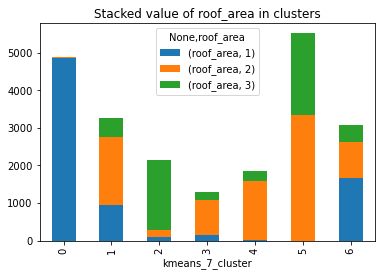

Catagorigal :  total_certifications


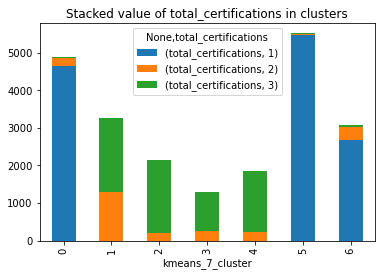

Catagorigal :  count_certified


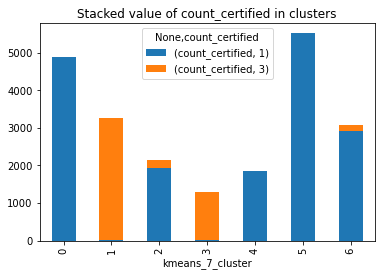

Catagorigal :  total_invoice_units


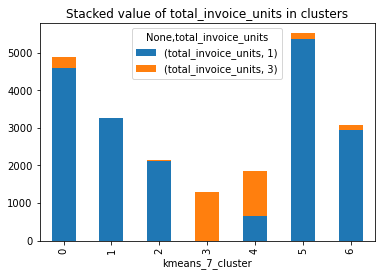

Catagorigal :  _2019_Steep_Slope_Residential


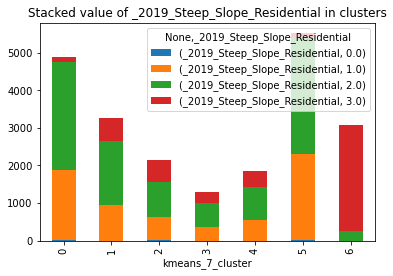

Catagorigal :  count_master_elite


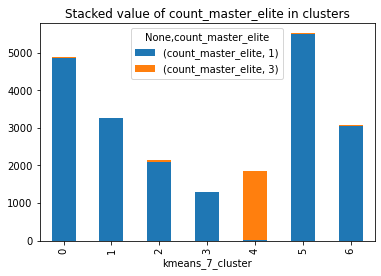

Catagorigal :  guar_warr_type_PLUS


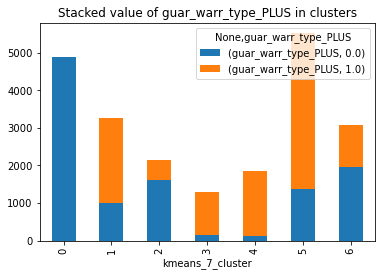

Catagorigal :  _2020_Steep_Slope_Residential


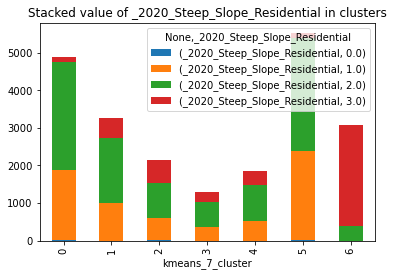

Catagorigal :  _2019_Low_Slope__Commercial


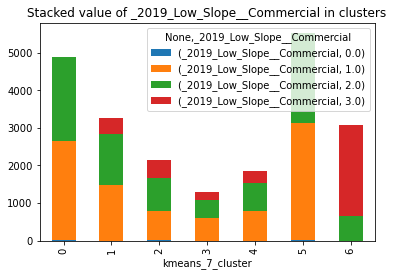

Catagorigal :  Steep_Slope_Residential


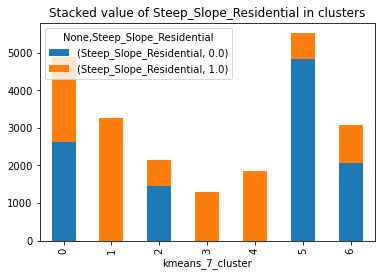

In [609]:
import warnings
warnings.filterwarnings('ignore')
for c in good_features:
    if 'cluster' in c or c in remove_col:
        pass
    else:
        
        #if feature is catagorigal show stacked bar
        if len(clean_data[c].value_counts().tolist())<=5:
            print('Catagorigal : ',c)
            my_df=pd.DataFrame(clean_data.groupby('kmeans_'+str(top_2[0])+'_cluster')[c].value_counts())
            my_df=pd.DataFrame(clean_data.groupby('kmeans_'+str(top_2[0])+'_cluster')[c].value_counts())
            my_df.unstack().plot(kind='bar', stacked=True)
            plt.title('Stacked value of '+c+' in clusters')        
        else:   
            ax1 = plt.subplot(221)
            my_df=clean_data.groupby('kmeans_'+str(top_2[0])+'_cluster')[c].mean().reset_index()
            my_df.plot(x='kmeans_'+str(top_2[0])+'_cluster', y=c, kind='bar',ax=ax1,figsize=(10, 5)) 
            plt.title('mean of '+c+' in clusters')
            my_df=clean_data.groupby('kmeans_'+str(top_2[0])+'_cluster')[c].mean().reset_index()
            my_df.plot(x='kmeans_'+str(top_2[0])+'_cluster', y=c, kind='bar',ax=ax1,figsize=(10, 5)) 
            my_df=clean_data.groupby('kmeans_'+str(top_2[0])+'_cluster')[c].std().reset_index()
            ax2 = plt.subplot(222)
            my_df.plot(x='kmeans_'+str(top_2[0])+'_cluster', y=c, kind='bar',ax=ax2,figsize=(10, 5)) 
            plt.title('SD of '+c+' in clusters')
        plt.show()
        
        
        


## Simple summary of clusters
#### cluster 0: mostly low values
#### cluster 1: high count_certified, Steep_Slope_Residential
#### cluster 2: high roof area,high total certification
#### cluster 3: (medium roof area,high total certification,)high count_certified, high total_invoice_units, guar_warr_type_PLUS, Steep_Slope_Residential
#### cluster 4: (medium roof area,high total certification),high total_invoice_units, high count_master_elite, guar_warr_type_PLUS, Steep_Slope_Residential
#### cluster 5: guar_warr_type_PLUS
#### cluster 6: _2019_Steep_Slope_Residential, high _2020_Steep_Slope_Residential, _2019_Low_Slope__Commercial

#### 0: low values, 6: sales good 5: guar_warr_type: PLUS 1: count_certified 2: good roof area 3: count_certified,total_invoice_units, guar_warr_type_PLUS 4: total_invoice_units, count_master_elite, guar_warr_type_PLUS

## SHow SVD components in different clusters

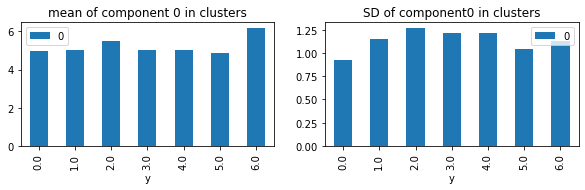

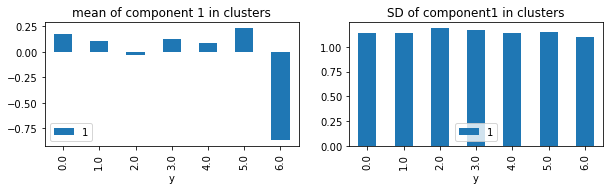

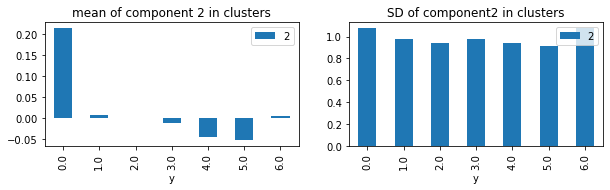

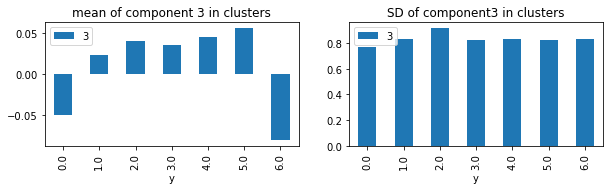

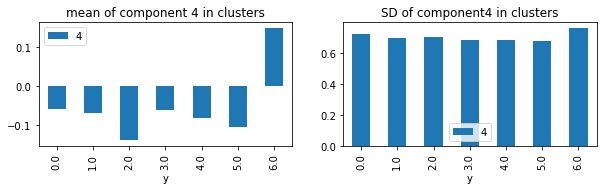

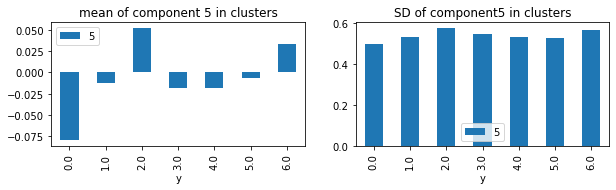

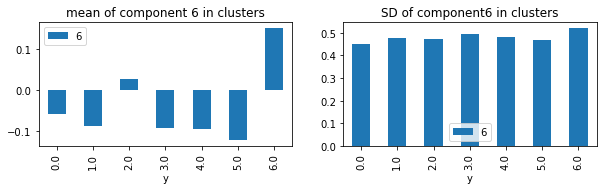

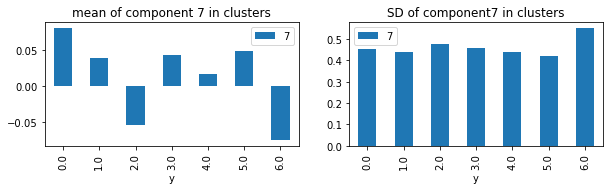

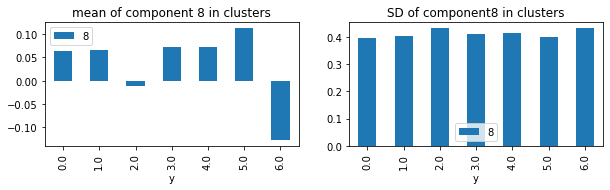

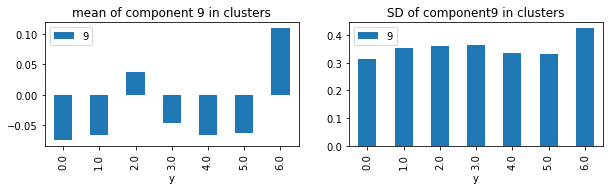

In [612]:
t=pd.DataFrame(np.array(x_orig))
t['y']=clean_data['kmeans_'+str(top_2[0])+'_cluster']
t

# plot with svd components
for c in t.columns.tolist():
        if c=='y':
            continue
        ax1 = plt.subplot(221)
        my_df=t.groupby('y')[c].mean().reset_index()
        my_df.plot(x='y', y=c, kind='bar',ax=ax1,figsize=(10, 5)) 
        plt.title('mean of component '+str(c)+' in clusters')
        my_df=t.groupby('y')[c].std().reset_index()
        ax2 = plt.subplot(222)
        my_df.plot(x='y', y=c, kind='bar',ax=ax2,figsize=(10, 5)) 
        plt.title('SD of component'+str(c)+' in clusters')
        plt.show()    

        

## Cluster analysis
#### Within each cluster distribution of all variables 

In [644]:
# Create dataframe to show for each cluster each variable value frequency
#variable importance in all cluster

raw_data_sub=final_data.copy()

# clusters feature importance
l11=[]
for cluster_name in range(top_2[0]):
    raw_data_sub_t=raw_data_sub[raw_data_sub['kmeans_'+str(top_2[0])+'_cluster']==cluster_name]

    
    for column in raw_data_sub_t.columns:
        if column not in ['cust_id','state','company_name','kmeans_'+str(top_2[0])+'_cluster','kmeans_'+str(top_2[0])+'_cluster_score','subcluster']:

            raw_data_sub_t[column]=raw_data_sub_t[column].fillna(0)
            l1=raw_data_sub_t[column].value_counts().tolist()
            l2=raw_data_sub_t[column].value_counts().index.tolist()
            l=raw_data_sub_t.shape[0]
            #print(column)
            

            # if more data then consider numeric
            if len(raw_data_sub_t[column].value_counts().index.tolist())>5:
                l10=[]
                #print('mean $$$$$$$$$$$value',raw_data_sub_t[column].mean())
                m=round(raw_data_sub_t[column].mean(),1)
                f1='NA'
                f='NA'
                d='NA'
                if column=='_2020_Low_Slope_Commercial':
                    print('val mean',raw_data_sub[column].mean())
                g_m=raw_data_sub[column].mean() 
                g_f='NA'
                clu=cluster_name
                l10.append(cluster_name)
                l10.append(column)
                l10.append(d)
                l10.append(f1)
                l10.append(f)
                l10.append(m)
                l10.append(g_f)
                l10.append(g_m)            
                l10.append(l)            
                l11.append(l10)
            else:
                for ll in range(len(l1)):
                    l10=[]
                    f1=l1[ll]
                    f=round(100*l1[ll]/l,1)
                    d=l2[ll]
                    m='NA'
                    if column=='_2020_Low_Slope_Commercial':
                        print('val freq',raw_data_sub[column].value_counts()[d])
                    g_f=raw_data_sub[column].value_counts()[d]    
                    g_m='NA'
                    clu=cluster_name
                    l10.append(cluster_name)
                    l10.append(column)
                    l10.append(d)
                    l10.append(f1)
                    l10.append(f)
                    l10.append(m)
                    l10.append(g_f)
                    l10.append(g_m)            
                    l10.append(l)            
                    l11.append(l10)

            
            

       
df=pd.DataFrame(l11,columns=['cluster','column','value','clusterfrequency','clusterpercentfrequency','mean','global_freq','global_mean','cluster_size']) 

df

,cluster,column,value,clusterfrequency,clusterpercentfrequency,mean,global_freq,global_mean,cluster_size
0,0,count_master,1.0,4808,98.3,NA,19997,NA,4891
1,0,count_master,3.0,83,1.7,NA,2093,NA,4891
2,0,count_certified,1.0,4891,100.0,NA,17126,NA,4891
3,0,count_master_elite,1.0,4866,99.5,NA,20104,NA,4891
4,0,count_master_elite,3.0,25,0.5,NA,1986,NA,4891
...,...,...,...,...,...,...,...,...,...
358,6,Guarantee,0.0,2742,88.9,NA,17263,NA,3084
359,6,Guarantee,1.0,342,11.1,NA,4827,NA,3084
360,6,total_certifications,1.0,2683,87.0,NA,12789,NA,3084
361,6,total_certifications,2.0,345,11.2,NA,2588,NA,3084


In [662]:
print('df shape',df.shape)
#final_data.groupby([''])


count=0
for clu in range(top_2[0]):
    for c in final_data.columns:
        if c not in ['cust_id','state','company_name','kmeans_7_cluster','kmeans_7_cluster_score']:
            if len(final_data[final_data['kmeans_'+str(top_2[0])+'_cluster']==clu][c].value_counts().index.tolist())<=5:
            #print(len(final_data[final_data['kmeans_'+str(top_2[0])+'_cluster']==clu][c].value_counts().tolist()))
                count=count+len(final_data[final_data['kmeans_'+str(top_2[0])+'_cluster']==clu][c].value_counts().tolist())
            else:
                count=count+1
            
print('total row in df should be',count)    
#final_data.head(1)
#final_data.groupby(['kmeans_7_cluster','count_master'])

df shape (363, 9)
total row in df should be 363


In [617]:
df[(df['value']!='NA') & (df['value']!=0)].sort_values(['cluster','clusterfrequency','value','mean'],ascending=False)

,cluster,column,value,clusterfrequency,clusterpercentfrequency,mean,global_freq,global_mean,cluster_size
154,6,count_CERTIFICATION_LEVEL_MASTER_SELECT,1.0,3078,99.8,NA,21475,NA,3084
152,6,count_master_elite,1.0,3050,98.9,NA,20104,NA,3084
150,6,count_master,1.0,3031,98.3,NA,19997,NA,3084
161,6,total_invoice_units,1.0,2952,95.7,NA,18957,NA,3084
153,6,count_CERTIFICATION_LEVEL_AUTHORIZED_LS,1.0,2940,95.3,NA,21361,NA,3084
...,...,...,...,...,...,...,...,...,...
24,0,total_certifications,1.0,4641,94.9,NA,12789,NA,4891
11,0,total_invoice_units,1.0,4594,93.9,NA,18957,NA,4891
9,0,_2019_Steep_Slope_Residential,2.0,2876,58.8,NA,10421,NA,4891
10,0,_2020_Steep_Slope_Residential,2.0,2871,58.7,NA,10502,NA,4891


#### Each variable distribution in all clusters

In [646]:
print(final_data['count_CERTIFICATION_LEVEL_AUTHORIZED_LS'].value_counts())
df[df['column']=='count_CERTIFICATION_LEVEL_AUTHORIZED_LS']['value'].value_counts()

1    21361
3      729
Name: count_CERTIFICATION_LEVEL_AUTHORIZED_LS, dtype: int64


3.0    7
1.0    7
Name: value, dtype: int64

#### count_master=1 is in clusters 0,1,3,4,5,6 and value 2 is only in cluster 2

In [648]:
col=final_data.columns
for c in col:
    print(c)
    print(df[df['column']==c].groupby(['value','cluster'])['clusterfrequency'].max().reset_index())

count_master
    value  cluster  clusterfrequency
0     1.0        0              4808
1     1.0        1              3249
2     1.0        2               576
3     1.0        3              1237
4     1.0        4              1578
5     1.0        5              5518
6     1.0        6              3031
7     3.0        0                83
8     3.0        1                28
9     3.0        2              1579
10    3.0        3                69
11    3.0        4               281
12    3.0        6                53
count_certified
    value  cluster  clusterfrequency
0     1.0        0              4891
1     1.0        1                 3
2     1.0        2              1929
3     1.0        3                 8
4     1.0        4              1858
5     1.0        5              5518
6     1.0        6              2919
7     3.0        1              3274
8     3.0        2               226
9     3.0        3              1298
10    3.0        4                 1
11    3.0

#### For example in cluster 6 99.8% count_CERTIFICATION_LEVEL_MASTER_SELECT=1, 98.9% count_master_elite=1

## Subcluster label analysis
#### We can choose top 4 clusters and form subcluster inside each and do analysis

## GMM

In [35]:
from sklearn.mixture import GaussianMixture as gmm
x=x_std
# with x_orig also giving 4 clusters

def gmmmodel(n_components=2,x=x):
    model=gmm(n_components=n_components)
    label=model.fit_predict(x)
    print('with cluster',n_components,'AIC',model.aic(x),'BIC',model.bic(x),'average log likelihood',model.score(x))
    aic=model.aic(x)
    return label,model,aic

aicno=100000
l=0
for n_components in range(2,5):     
    label,model,aic=gmmmodel(n_components,x)
    if aic< aicno:
        aicno=aic
        l=n_components
    
print(model.weights_,'best component',l)
#print('model means before trans',model.means_)

#print('model means after trans',scaler.inverse_transform(model.means_))

with cluster 2 AIC -111365.51393668319 BIC -109187.13988083733 average log likelihood 2.4448901934956564
with cluster 3 AIC -446200.44451520895 BIC -442928.8642911157 average log likelihood 9.766111258306584
with cluster 4 AIC -498087.2632916359 BIC -493722.47689929535 average log likelihood 10.905646755475747
[0.0985229  0.6953471  0.17682213 0.02930787] best component 4


#### make 10 cluster in gmm

In [355]:
l=10

In [357]:
from sklearn.mixture import GaussianMixture as gmm
model=gmm(n_components=l)
label=model.fit_predict(x)

print('value counts',Counter(label).values())

value counts dict_values([1020, 12140, 2779, 1686, 416, 1067, 1878, 317, 250, 537])


In [358]:
# no of cluster = 2 has low logscore and aic bic 

model=gmm(n_components=l)
label=model.fit_predict(x)
#print(label) 
top_2_gmm=l
final_data['gmm_'+str(l)+'_cluster']=label
final_data['gmm_'+str(l)+'_cluster_log_score']=model.score(x)
clean_data['gmm_'+str(l)+'_cluster']=label
clean_data['gmm_'+str(l)+'_cluster_log_score']=model.score(x)

In [361]:
final_data.head(2)

,count_master,count_certified,count_master_elite,count_CERTIFICATION_LEVEL_AUTHORIZED_LS,count_CERTIFICATION_LEVEL_MASTER_SELECT,Steep_Slope_Residential,Low_Slope_Commercial,CommercialCertification_Master_Select,CommercialCertification_Master,CommercialCertification_Authorized_LS,ResidentialCertification_Master_Elite,ResidentialCertification_Certified,_2019_Low_Slope__Commercial,_2019_Steep_Slope_Residential,_2020_Low_Slope_Commercial,_2020_Steep_Slope_Residential,total_invoice_units,total_value_of_invoices_submitted_ytd,guar_warr_type_PLUS,guar_warr_type_GOLD,guar_warr_type_CASP,guar_warr_type_EVERGUARD_DIAMOND_PLEDGE,guar_warr_type_SILV,guar_warr_type_RUBEROID_DIAMOND_PLEDGE,guar_warr_type_GAFGLAS_DIAMOND_PLEDGE,guar_warr_type_INTEC_MODIFIED_NDL_GUARANTEE,guar_warr_type_HDPH,guar_warr_type_INTEGRATED_SYSTEM,roof_area,Warranty,Guarantee,total_certifications,kmeans_10_cluster,kmeans_10_cluster_score,cust_id,state,company_name,gmm_10_cluster,gmm_10_cluster_log_score
67,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,1.0,6,0.2614,1106740,AK,United Roofing Group Inc,8,107.628601
68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,1,0.2614,1118433,AK,T & M Enterprises,3,107.628601


## DBSCAN

In [334]:
x=x_std
# with x_orig giving 1 clusters
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
sscore=-100
eps1=.5
dbscab_label=0
for eps in [.3,.35,.25,.4,.5]:
    db = DBSCAN(eps=eps, min_samples=600).fit(x)
    #db = dbscan(x,eps=eps, min_samples=200)
    #labels=db.labels_
    labels=db.labels_
    cluster=len(set(labels)) - (1 if -1 in labels else 0)
    # -1 labels are outliers
    score=metrics.silhouette_score(x,labels)
    print('DBSCAN no of cluster by model',len(set(labels)),cluster,score)
    if score>sscore:
        sscore=score
        eps1=eps
        dbscab_label=labels
        
        
print('best eps',eps1)

print('value counts',Counter(dbscab_label).values())

db = DBSCAN(eps=eps1, min_samples=600).fit(x)
labels=db.labels_
score=metrics.silhouette_score(x,labels)
top_2_dbscan=len(set(labels))    
final_data['dbscan_'+str(len(set(labels)))+'_cluster']=labels
final_data['dbscan_'+str(len(set(labels)))+'_cluster_score']=score
clean_data['dbscan_'+str(len(set(labels)))+'_cluster']=label
clean_data['dbscan_'+str(len(set(labels)))+'_cluster_score']=score
clean_data.head(2)


DBSCAN no of cluster by model 6 5 -0.1530314595243076
DBSCAN no of cluster by model 6 5 -0.15225526820669333
DBSCAN no of cluster by model 6 5 -0.15434075520612645
DBSCAN no of cluster by model 6 5 -0.15172054267224247
DBSCAN no of cluster by model 6 5 -0.15143218353747107
best eps 0.5
value counts dict_values([17811, 751, 1031, 760, 797, 940])


,CERTIFICATION_LEVEL_MASTER,CERTIFICATION_LEVEL_CERTIFIED,CERTIFICATION_LEVEL_MASTER_ELITE,CERTIFICATION_LEVEL_AUTHORIZED_LS,CERTIFICATION_LEVEL_MASTER_SELECT,count_master,count_certified,count_master_elite,count_CERTIFICATION_LEVEL_AUTHORIZED_LS,count_CERTIFICATION_LEVEL_MASTER_SELECT,Steep_Slope_Residential,Low_Slope_Commercial,CommercialCertification_Master_Select,CommercialCertification_Master,CommercialCertification_Authorized_LS,ResidentialCertification_Master_Elite,ResidentialCertification_Certified,_2019_Low_Slope__Commercial,_2019_Steep_Slope_Residential,_2020_Low_Slope_Commercial,_2020_Steep_Slope_Residential,points_redeemed,total_invoice_units,total_value_of_invoices_submitted_ytd,guar_warr_type_PLUS,guar_warr_type_GOLD,guar_warr_type_CASP,guar_warr_type_EVERGUARD_DIAMOND_PLEDGE,guar_warr_type_SILV,guar_warr_type_RUBEROID_DIAMOND_PLEDGE,guar_warr_type_GAFGLAS_DIAMOND_PLEDGE,guar_warr_type_INTEC_MODIFIED_NDL_GUARANTEE,guar_warr_type_HDPH,guar_warr_type_INTEGRATED_SYSTEM,roof_area,Warranty,Guarantee,total_certifications,kmeans_2_cluster,kmeans_2_cluster_score,gmm_4_cluster,gmm_4_cluster_log_score,dbscan_13_cluster,dbscan_13_cluster_score,kmeans_6_cluster,kmeans_6_cluster_score,gmm_6_cluster,gmm_6_cluster_log_score,dbscan_6_cluster,dbscan_6_cluster_score
67,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.439086,3,15.252212,3,0.090983,3,0.24063,3,25.671814,3,-0.151432
68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.439086,0,15.252212,0,0.090983,5,0.24063,5,25.671814,5,-0.151432


In [336]:
final_data.head(2)

,company_name,state,country,cust_id,CERTIFICATION_LEVEL_MASTER,CERTIFICATION_LEVEL_CERTIFIED,CERTIFICATION_LEVEL_MASTER_ELITE,CERTIFICATION_LEVEL_AUTHORIZED_LS,CERTIFICATION_LEVEL_MASTER_SELECT,count_master,count_certified,count_master_elite,count_CERTIFICATION_LEVEL_AUTHORIZED_LS,count_CERTIFICATION_LEVEL_MASTER_SELECT,Steep_Slope_Residential,Low_Slope_Commercial,CommercialCertification_Master_Select,CommercialCertification_Master,CommercialCertification_Authorized_LS,ResidentialCertification_Master_Elite,ResidentialCertification_Certified,_2019_Low_Slope__Commercial,_2019_Steep_Slope_Residential,_2020_Low_Slope_Commercial,_2020_Steep_Slope_Residential,points_available,points_redeemed,total_invoice_units,total_value_of_invoices_submitted_ytd,guar_warr_type_PLUS,guar_warr_type_GOLD,guar_warr_type_CASP,guar_warr_type_EVERGUARD_DIAMOND_PLEDGE,guar_warr_type_SILV,guar_warr_type_RUBEROID_DIAMOND_PLEDGE,guar_warr_type_GAFGLAS_DIAMOND_PLEDGE,guar_warr_type_INTEC_MODIFIED_NDL_GUARANTEE,guar_warr_type_HDPH,guar_warr_type_INTEGRATED_SYSTEM,roof_area,Warranty,Guarantee,kmeans_6_cluster,kmeans_6_cluster_score,gmm_6_cluster,gmm_6_cluster_log_score,dbscan_6_cluster,dbscan_6_cluster_score
67,United Roofing Group Inc,AK,USA,1106740,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0.24063,3,25.671814,-1,-0.151432
68,T & M Enterprises,AK,USA,1118433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,0.24063,5,25.671814,0,-0.151432


In [338]:
17811+751+1031+760+797+940
17811/22090			count_CERTIFICATION_LEVEL_AUTHORIZED_LS	count_CERTIFICATION_LEVEL_MASTER_SELECT 	count_CERTIFICATION_LEVEL_AUTHORIZED_LS	count_CERTIFICATION_LEVEL_MASTER_SELECT
count_master	count_certified	count_master_elite count_master  count_certified	count_master_elite

0.8062924400181077

## AgglomerativeClustering

In [50]:
x=x_orig
for cluster in [4]:
    model=AgglomerativeClustering(n_clusters=cluster).fit(x)
    final_data['hierarchical_'+str(cluster)+'_cluster']=model.labels_
    final_data['hierarchical_'+str(cluster)+'_cluster_score']='NA'
    clean_data['hierarchical_'+str(cluster)+'_cluster']=model.labels_
    clean_data['hierarchical_'+str(cluster)+'_cluster_score']='NA'
top_2_agg=4
    

In [51]:
print(final_data.shape)
#final_data.head(1)

(14347, 38)


In [52]:
print(clean_data.shape)
clean_data.head(1)

(14347, 36)


,CERTIFICATION_LEVEL_MASTER,CERTIFICATION_LEVEL_CERTIFIED,CERTIFICATION_LEVEL_MASTER_ELITE,CERTIFICATION_LEVEL_AUTHORIZED_LS,CERTIFICATION_LEVEL_MASTER_SELECT,count_master,count_certified,count_master_elite,count_CERTIFICATION_LEVEL_AUTHORIZED_LS,count_CERTIFICATION_LEVEL_MASTER_SELECT,Steep_Slope_Residential,Low_Slope_Commercial,CommercialCertification_Master_Select,CommercialCertification_Master,CommercialCertification_Authorized_LS,ResidentialCertification_Master_Elite,ResidentialCertification_Certified,ResidentialCertification_AUTHORIZED_HB,_2019_Low_Slope__Commercial,_2019_Steep_Slope_Residential,_2020_Low_Slope_Commercial,_2020_Steep_Slope_Residential,record_type_warranty,record_type_guarantee,roof_area,points_available,points_redeemed,total_certifications,kmeans_9_cluster,kmeans_9_cluster_score,gmm_4_cluster,gmm_4_cluster_log_score,dbscan_2_cluster,dbscan_2_cluster_score,hierarchical_4_cluster,hierarchical_4_cluster_score
0,0.0,1.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,31.649123,245.07,0.0,11.0,1,0.411117,3,-1.725101,3,0.536483,1,NA


In [53]:
#clean_data=clean_data.drop(['kmeans_2_cluster_score','kmeans_2_cluster'],axis=1)

## Merge clusters output and store back to bigquery

In [311]:
# merge original data with cluster labels
#final_data has input for model
use_col=[c for c in final_data.columns.tolist() if 'cluster' in c]
use_col.append('cust_id')
print(use_col)
final_data1=final_data[use_col]
final_data1.head(2)

#drop columns from bas data where clusetr 
drop_col=[c for c in base_data.columns.tolist() if 'cluster' in c]
base_data1=base_data.drop(drop_col,axis=1)
print(base_data1.shape)
print(base_data.shape)

#final2 has data original+cluster label
final2=pd.merge(base_data1,final_data1,how='left', on='cust_id')
print(final_data1.shape,base_data1.shape,final2.shape)

['kmeans_2_cluster', 'kmeans_2_cluster_score', 'gmm_4_cluster', 'gmm_4_cluster_log_score', 'dbscan_13_cluster', 'dbscan_13_cluster_score', 'cust_id']
(75246, 12)
(75246, 15)
(22090, 7) (75246, 12) (75246, 18)


In [3]:
#final_data.head(1)

In [4]:
#final_data.head(1)


(22090, 39)

In [884]:
# Store feature data with label
#final_data.to_gbq(destination_table='Contractor_Cluster.Contractor_Featured_Cluster_updated_20_5_temp',project_id = '*',if_exists = 'replace')  #'replace')

1it [00:06,  6.03s/it]


In [329]:
final_data['kmeans_10_cluster'].value_counts()

2    5031
3    4517
1    3629
9    3151
0    1551
7    1467
5    1456
6     708
4     579
8       1
Name: kmeans_10_cluster, dtype: int64

## FInd important features of clusters

In [929]:
# for kmeans
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
drop_col=[c for c in clean_data.columns.tolist() if 'cluster' in c]
x=clean_data.drop(drop_col, axis=1).values 
y=clean_data['kmeans_'+str(top_2[0])+'_cluster']
clf.fit(x, y)
feat_importance = clf.tree_.compute_feature_importances(normalize=False)
print("feat importance = " + str(feat_importance))
good_features=[]
for importance, name in sorted(zip(clf.feature_importances_, clean_data.drop(['kmeans_'+str(top_2[0])+'_cluster'], axis=1).columns),reverse=True)[:10]:
    print (name, importance)
    good_features.append(name)
    
good_features

feat importance = [1.47131382e-02 5.30250719e-02 2.31156073e-02 3.69772138e-02
 1.39336682e-02 4.59988664e-03 7.15205984e-02 1.54314144e-02
 1.38492531e-02 8.23420165e-02 3.75669482e-03 5.92230409e-03
 0.00000000e+00 2.94231545e-03 4.60482007e-02 1.83418654e-02
 1.37435659e-01 3.02328559e-02 1.87076032e-02 3.74996807e-02
 1.00093584e-03 6.25221512e-03 9.85747019e-04 4.74594594e-03
 5.16155233e-03 1.38490975e-02 1.83843741e-02 4.10491335e-03
 8.86808676e-05 3.64339993e-03 6.01710036e-02 7.60852908e-02
 3.40517819e-02 4.62024796e-02]
_2020_Low_Slope_Commercial 0.15184205940250428
ResidentialCertification_REWARDS 0.0909733429256032
Warranty 0.08406076930035788
Steep_Slope_Residential 0.07901759279227315
roof_area 0.06647830086961307
count_certified 0.05858331213293006
total_certifications 0.05104555613384613
_2019_Low_Slope__Commercial 0.05087510523976376
total_value_of_invoices_submitted_ytd 0.04143050480615015
count_CERTIFICATION_LEVEL_AUTHORIZED_LS 0.04085327147042342


['_2020_Low_Slope_Commercial',
 'ResidentialCertification_REWARDS',
 'Warranty',
 'Steep_Slope_Residential',
 'roof_area',
 'count_certified',
 'total_certifications',
 '_2019_Low_Slope__Commercial',
 'total_value_of_invoices_submitted_ytd',
 'count_CERTIFICATION_LEVEL_AUTHORIZED_LS']

(22090, 34)

In [348]:
clean_data.head(1)

,count_master,count_certified,count_master_elite,count_CERTIFICATION_LEVEL_AUTHORIZED_LS,count_CERTIFICATION_LEVEL_MASTER_SELECT,Steep_Slope_Residential,Low_Slope_Commercial,CommercialCertification_Master_Select,CommercialCertification_Master,CommercialCertification_Authorized_LS,ResidentialCertification_Master_Elite,ResidentialCertification_Certified,_2019_Low_Slope__Commercial,_2019_Steep_Slope_Residential,_2020_Low_Slope_Commercial,_2020_Steep_Slope_Residential,total_invoice_units,total_value_of_invoices_submitted_ytd,guar_warr_type_PLUS,guar_warr_type_GOLD,guar_warr_type_CASP,guar_warr_type_EVERGUARD_DIAMOND_PLEDGE,guar_warr_type_SILV,guar_warr_type_RUBEROID_DIAMOND_PLEDGE,guar_warr_type_GAFGLAS_DIAMOND_PLEDGE,guar_warr_type_INTEC_MODIFIED_NDL_GUARANTEE,guar_warr_type_HDPH,guar_warr_type_INTEGRATED_SYSTEM,roof_area,Warranty,Guarantee,total_certifications,kmeans_10_cluster,kmeans_10_cluster_score
67,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,1.0,6,0.2614


In [349]:
clean_data.head(1)

,count_master,count_certified,count_master_elite,count_CERTIFICATION_LEVEL_AUTHORIZED_LS,count_CERTIFICATION_LEVEL_MASTER_SELECT,Steep_Slope_Residential,Low_Slope_Commercial,CommercialCertification_Master_Select,CommercialCertification_Master,CommercialCertification_Authorized_LS,ResidentialCertification_Master_Elite,ResidentialCertification_Certified,_2019_Low_Slope__Commercial,_2019_Steep_Slope_Residential,_2020_Low_Slope_Commercial,_2020_Steep_Slope_Residential,total_invoice_units,total_value_of_invoices_submitted_ytd,guar_warr_type_PLUS,guar_warr_type_GOLD,guar_warr_type_CASP,guar_warr_type_EVERGUARD_DIAMOND_PLEDGE,guar_warr_type_SILV,guar_warr_type_RUBEROID_DIAMOND_PLEDGE,guar_warr_type_GAFGLAS_DIAMOND_PLEDGE,guar_warr_type_INTEC_MODIFIED_NDL_GUARANTEE,guar_warr_type_HDPH,guar_warr_type_INTEGRATED_SYSTEM,roof_area,Warranty,Guarantee,total_certifications,kmeans_10_cluster,kmeans_10_cluster_score
67,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,1.0,6,0.2614


## Show data variablility in clusters

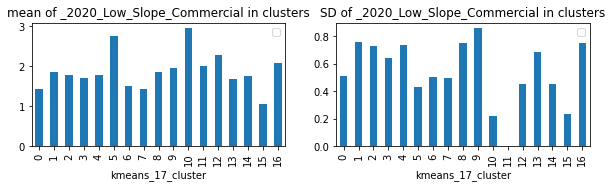

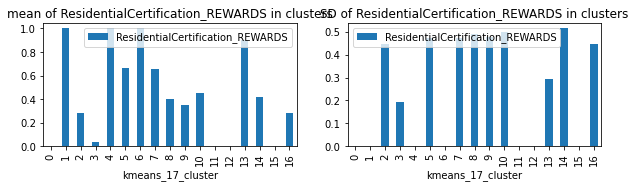

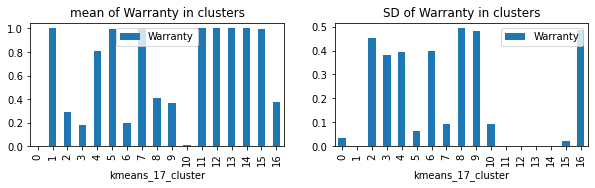

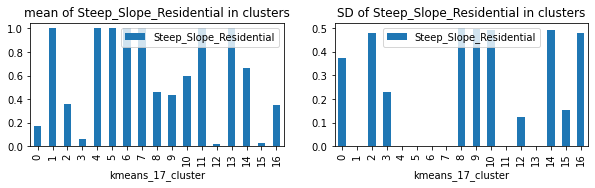

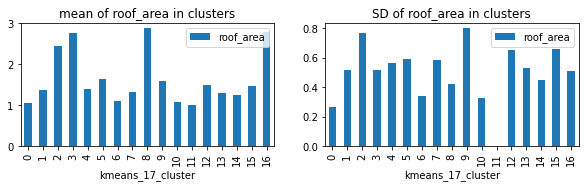

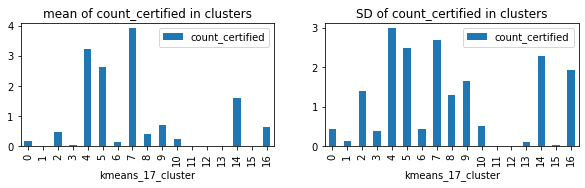

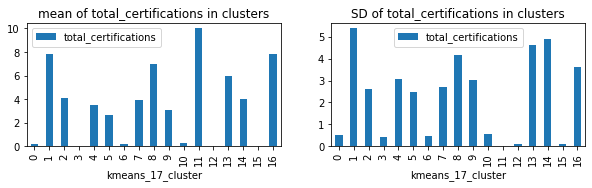

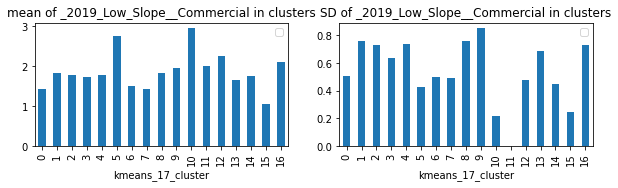

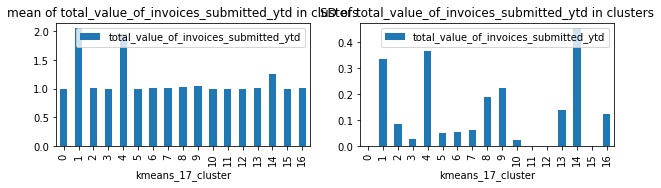

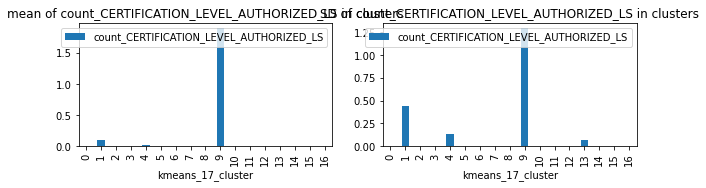

In [930]:
import warnings
warnings.filterwarnings('ignore')
for c in good_features:
    if 'cluster' in c or c in remove_col:
        pass
    else:
        
        #print('kmeans clusters mean/std value ',c,' in different clusters\n')
        #print('---------------------------------')
        ax1 = plt.subplot(221)
        my_df=clean_data.groupby('kmeans_'+str(top_2[0])+'_cluster')[c].mean().reset_index()
        my_df.plot(x='kmeans_'+str(top_2[0])+'_cluster', y=c, kind='bar',ax=ax1,figsize=(10, 5)) 
        plt.title('mean of '+c+' in clusters')
        #plt.subplot(1, 2, 2)
        my_df=clean_data.groupby('kmeans_'+str(top_2[0])+'_cluster')[c].std().reset_index()
        ax2 = plt.subplot(222)
        my_df.plot(x='kmeans_'+str(top_2[0])+'_cluster', y=c, kind='bar',ax=ax2,figsize=(10, 5)) 
        plt.title('SD of '+c+' in clusters')
        plt.show()
        #print(clean_data.groupby('gmm_4_cluster')[c].mean().reset_index())


In [61]:
clean_data.head(2)

,CERTIFICATION_LEVEL_MASTER,CERTIFICATION_LEVEL_CERTIFIED,CERTIFICATION_LEVEL_MASTER_ELITE,CERTIFICATION_LEVEL_AUTHORIZED_LS,CERTIFICATION_LEVEL_MASTER_SELECT,count_master,count_certified,count_master_elite,count_CERTIFICATION_LEVEL_AUTHORIZED_LS,count_CERTIFICATION_LEVEL_MASTER_SELECT,Steep_Slope_Residential,Low_Slope_Commercial,CommercialCertification_Master_Select,CommercialCertification_Master,CommercialCertification_Authorized_LS,ResidentialCertification_Master_Elite,ResidentialCertification_Certified,ResidentialCertification_AUTHORIZED_HB,_2019_Low_Slope__Commercial,_2019_Steep_Slope_Residential,_2020_Low_Slope_Commercial,_2020_Steep_Slope_Residential,record_type_warranty,record_type_guarantee,roof_area,points_available,points_redeemed,total_certifications,kmeans_9_cluster,kmeans_9_cluster_score,gmm_4_cluster,gmm_4_cluster_log_score,dbscan_2_cluster,dbscan_2_cluster_score,hierarchical_4_cluster,hierarchical_4_cluster_score
0,0.0,1.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,31.649123,245.07,0.0,11.0,1,0.411117,3,-1.725101,3,0.536483,1,NA
1,0.0,1.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,35.932990,928.83,0.0,11.0,1,0.411117,3,-1.725101,3,0.536483,1,NA


## Feature importance from GMM

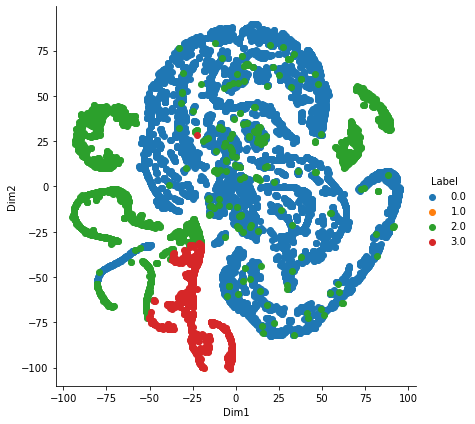

In [62]:
# t-SNE for GMM
modeltsne=TSNE(n_components=2,random_state=0)#,perplexity=10,n_iter=250)
model=gmm(n_components=top_2_gmm)
label=model.fit_predict(x_orig)
y=label
tsne_data=modeltsne.fit_transform(x)
#create new data for plotting
tsne_data=np.vstack((tsne_data.T,y)).T
tsne_df=pd.DataFrame(data=tsne_data,columns=('Dim1','Dim2','Label'))
sns.FacetGrid(tsne_df,hue='Label',size=6).map(plt.scatter,'Dim1','Dim2').add_legend()
plt.show()

feat importance = [4.59360158e-04 0.00000000e+00 1.92291576e-01 0.00000000e+00
 2.21138403e-04 0.00000000e+00 2.57677564e-01 0.00000000e+00
 1.45358196e-02 1.13676759e-02 1.94967784e-04 4.15815301e-02
 2.09944474e-03 0.00000000e+00 2.95263593e-02 2.77886693e-04
 0.00000000e+00 3.46150151e-04 6.97009828e-05 1.00679197e-04
 1.97486118e-04 3.37944159e-05 3.26126960e-03 1.26729060e-04
 7.14870762e-03 8.96059854e-03 1.39110233e-02 1.48044927e-02]
count_certified 0.43004032678230314
CERTIFICATION_LEVEL_MASTER_ELITE 0.3209170833833049
Low_Slope_Commercial 0.06939577699945494
CommercialCertification_Authorized_LS 0.049276797718216
total_certifications 0.02470734661505769


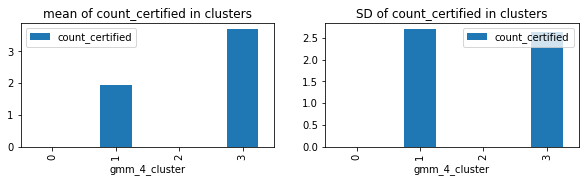

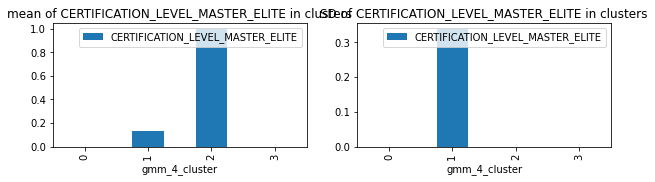

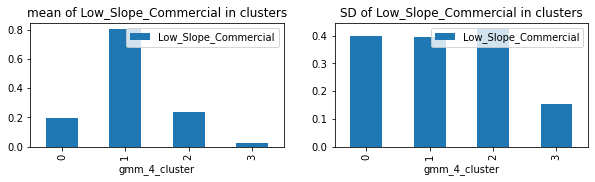

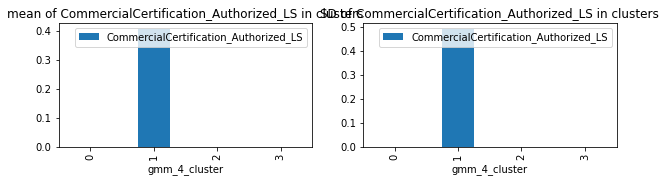

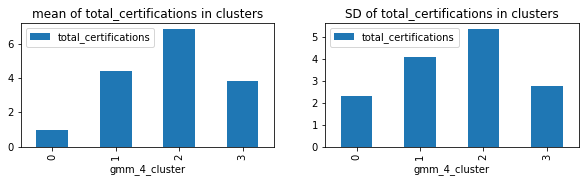

In [63]:
# for gmm
clf = DecisionTreeClassifier()
drop_col=[c for c in clean_data.columns.tolist() if 'cluster' in c]
x=clean_data.drop(drop_col, axis=1).values 
y=clean_data['gmm_'+str(top_2_gmm)+'_cluster']
clf.fit(x, y)
feat_importance = clf.tree_.compute_feature_importances(normalize=False)
print("feat importance = " + str(feat_importance))
good_features=[]
for importance, name in sorted(zip(clf.feature_importances_, clean_data.drop(['gmm_'+str(top_2_gmm)+'_cluster'], axis=1).columns),reverse=True)[:5]:
    print (name, importance)
    good_features.append(name)
    
good_features

for c in good_features:
        ax1 = plt.subplot(221)
        my_df=clean_data.groupby('gmm_'+str(top_2_gmm)+'_cluster')[c].mean().reset_index()
        my_df.plot(x='gmm_'+str(top_2_gmm)+'_cluster', y=c, kind='bar',ax=ax1,figsize=(10, 5)) 
        plt.title('mean of '+c+' in clusters')
        my_df=clean_data.groupby('gmm_'+str(top_2_gmm)+'_cluster')[c].std().reset_index()
        ax2 = plt.subplot(222)
        my_df.plot(x='gmm_'+str(top_2_gmm)+'_cluster', y=c, kind='bar',ax=ax2,figsize=(10, 5)) 
        plt.title('SD of '+c+' in clusters')
        plt.show()    
        



## For DBSCAN

In [512]:
final_data['gmm_4_cluster'].value_counts()

0    13856
3      489
2        1
1        1
Name: gmm_4_cluster, dtype: int64

[0, 1, 2, 3, 4, 'y']

## Plot SVD components with cluster

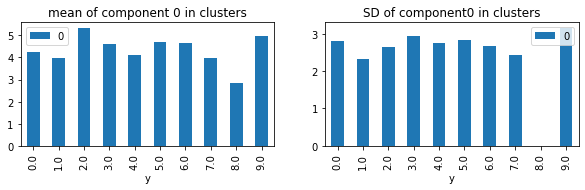

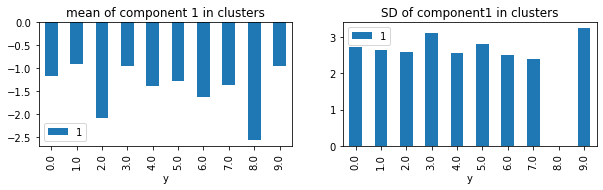

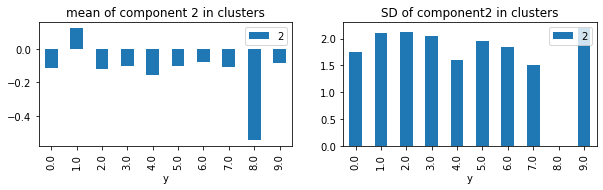

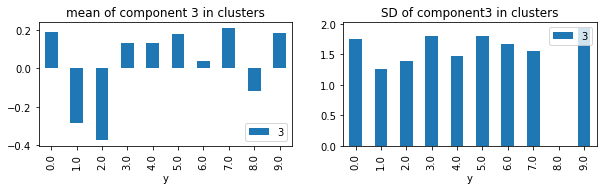

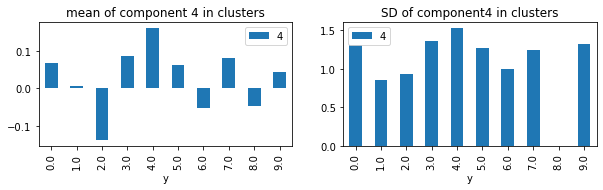

In [353]:
t=pd.DataFrame(np.array(x_orig))
t['y']=clean_data['kmeans_10_cluster']
t

# plot with svd components
for c in t.columns.tolist():
        if c=='y':
            continue
        ax1 = plt.subplot(221)
        my_df=t.groupby('y')[c].mean().reset_index()
        my_df.plot(x='y', y=c, kind='bar',ax=ax1,figsize=(10, 5)) 
        plt.title('mean of component '+str(c)+' in clusters')
        my_df=t.groupby('y')[c].std().reset_index()
        ax2 = plt.subplot(222)
        my_df.plot(x='y', y=c, kind='bar',ax=ax2,figsize=(10, 5)) 
        plt.title('SD of component'+str(c)+' in clusters')
        plt.show()    

        

In [347]:
t.columns

Index([0, 1, 2, 3, 4, 'y'], dtype='object')